# Prepare data

[data_preparation notebook](data_preparation.ipynb)

## Column names

Fixed column names:
- changed column names
    - `engin_size` -> `engine_size`
    - `bodytype` -> `body_type`
    - `runned_miles` -> `run_miles`
- made all column names lowercase

## Duplicates

Removed 889 duplicated columns (values in all columns the same except for `adv_id`)

## Column by column walkthrough:

- `adv_id`
    - index of dataframe
- `maker`
- `genmodel`
    - one `genmodel` can have multiple `genmodel_id` (did nothing)
- `genmodel_id`
    - one `genmodel_id` can have multiple `genmodel` (did nothing)
- `adv_year`
    - everything seems fine
- `adv_month`
    -  removed 3 rows with value '>12'
- `color`
    - changed type to category
- `reg_year`
    - removed 6 rows with missing `reg_year` (most columns are missing)
- `body_type`
    - swapped `body_type` with `gearbox` for columns with `body_type` == 'Manual'
- `run_miles`
    - replaced '1 mile' with number
    - changed type to float
    - removed 1 row with average daily milage of around 1000 miles
- `engine_size`
    - got rid of 'L'
    - changed type to float
    - divided values of 3 rows by 1000 (seems like a different unit of measurement)
- `gearbox`
    - changed type to category
- `fuel_type`
    - mapped synonyms to one value
    - changed type to category (*)
- `price` 
    - removed 1120 rows with missing `price`
    - removed 1 row with value of 9,999,999
- `engine_power`
    - everything seems fine
- `annual_tax`
    - got rid of '*'
    - changed type to float
- `wheelbase`
    - replaced 0 with NaN
- `height`
    - replaced values '<1000' with NaN
- `width`
    - everything seems fine
- `length`
    - replaced 0 with NaN
- `average_mpg`
    - got rid of 'mpg'
    - changed type to float
    - values way above normal values (did nothing, hybrid/electric cars*)
- `top_speed`
    - got rid of 'mph'
    - changed type to float
    - replaced 11 with NaN
- `seat_num`
    - replaced 1 with NaN
- `door_num`
    - replaced 0 with NaN 

## Missing data

Filled:
- `body_type`
- `engine_size`
- `fuel_type`
- `engine_power`
- `wheelbase`
- `height`
- `weight`
- `length`
- `seat_num`
- `door_num`

columns with the average for a given `genmodel_id`.

# Data exploration and visualization

[data_exploration notebook](data_exploration.ipynb)
[data_visualization notebook](data_visualization.ipynb)

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import kstest, kruskal
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [2]:
cars = pd.read_csv('../data/processed_capstone_data.csv', index_col='adv_id')
cars['log_price'] = np.log10(cars['price'])

## Price distribution

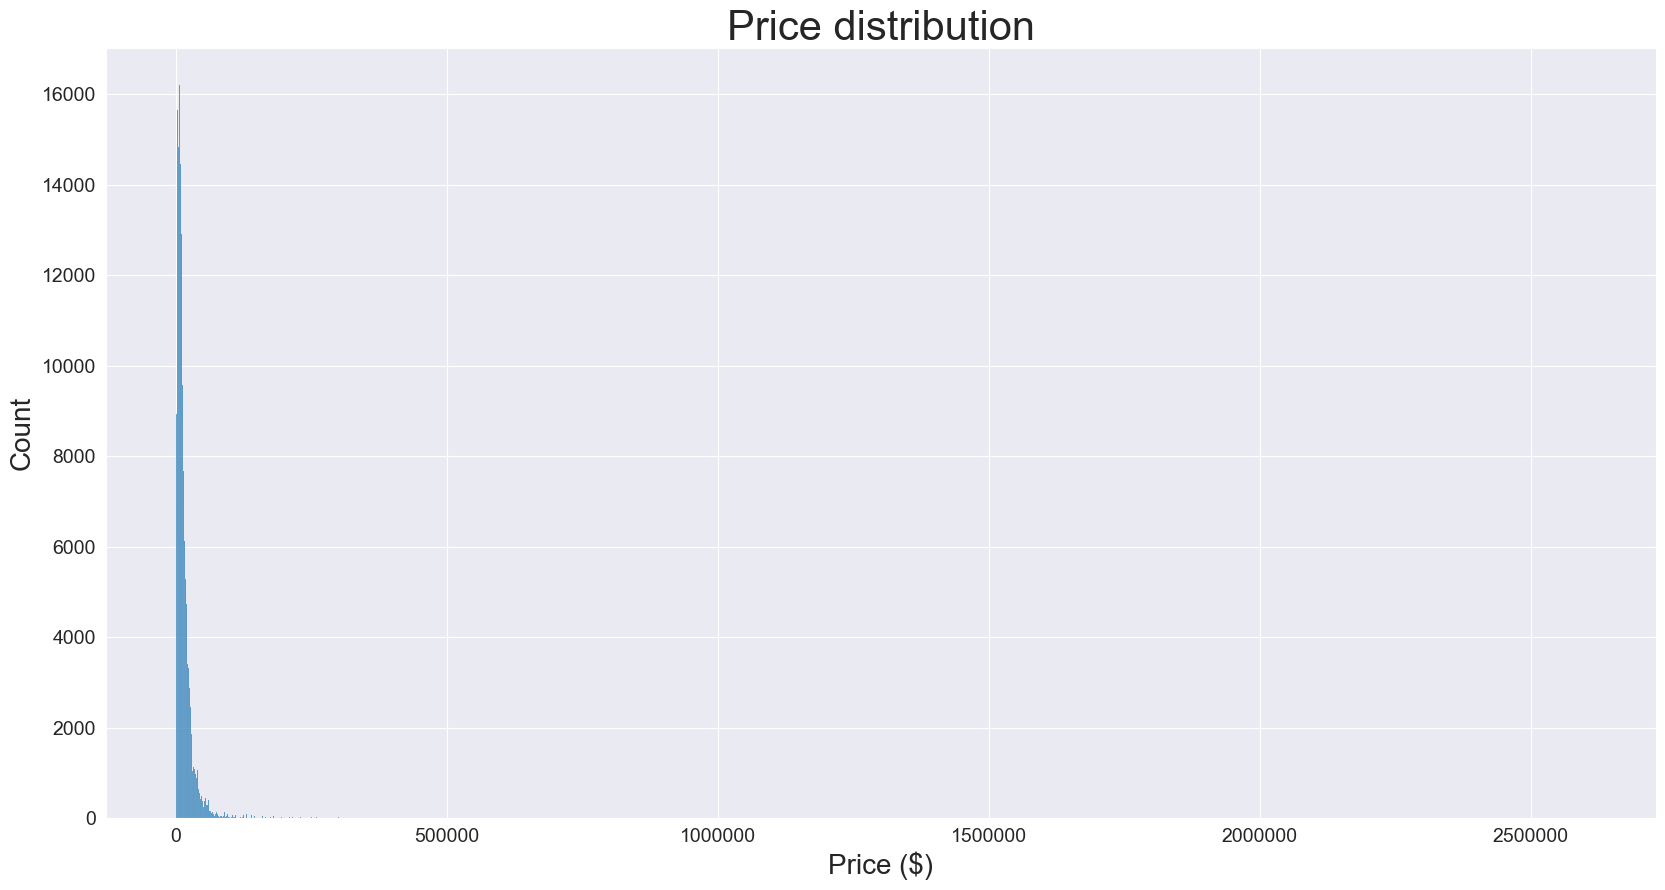

In [3]:
plt.figure(figsize=(20, 10))
sns.histplot(data=cars, x='price', binwidth=1000)
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
plt.xlabel('Price ($)', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Price distribution', fontsize=30)
plt.show()

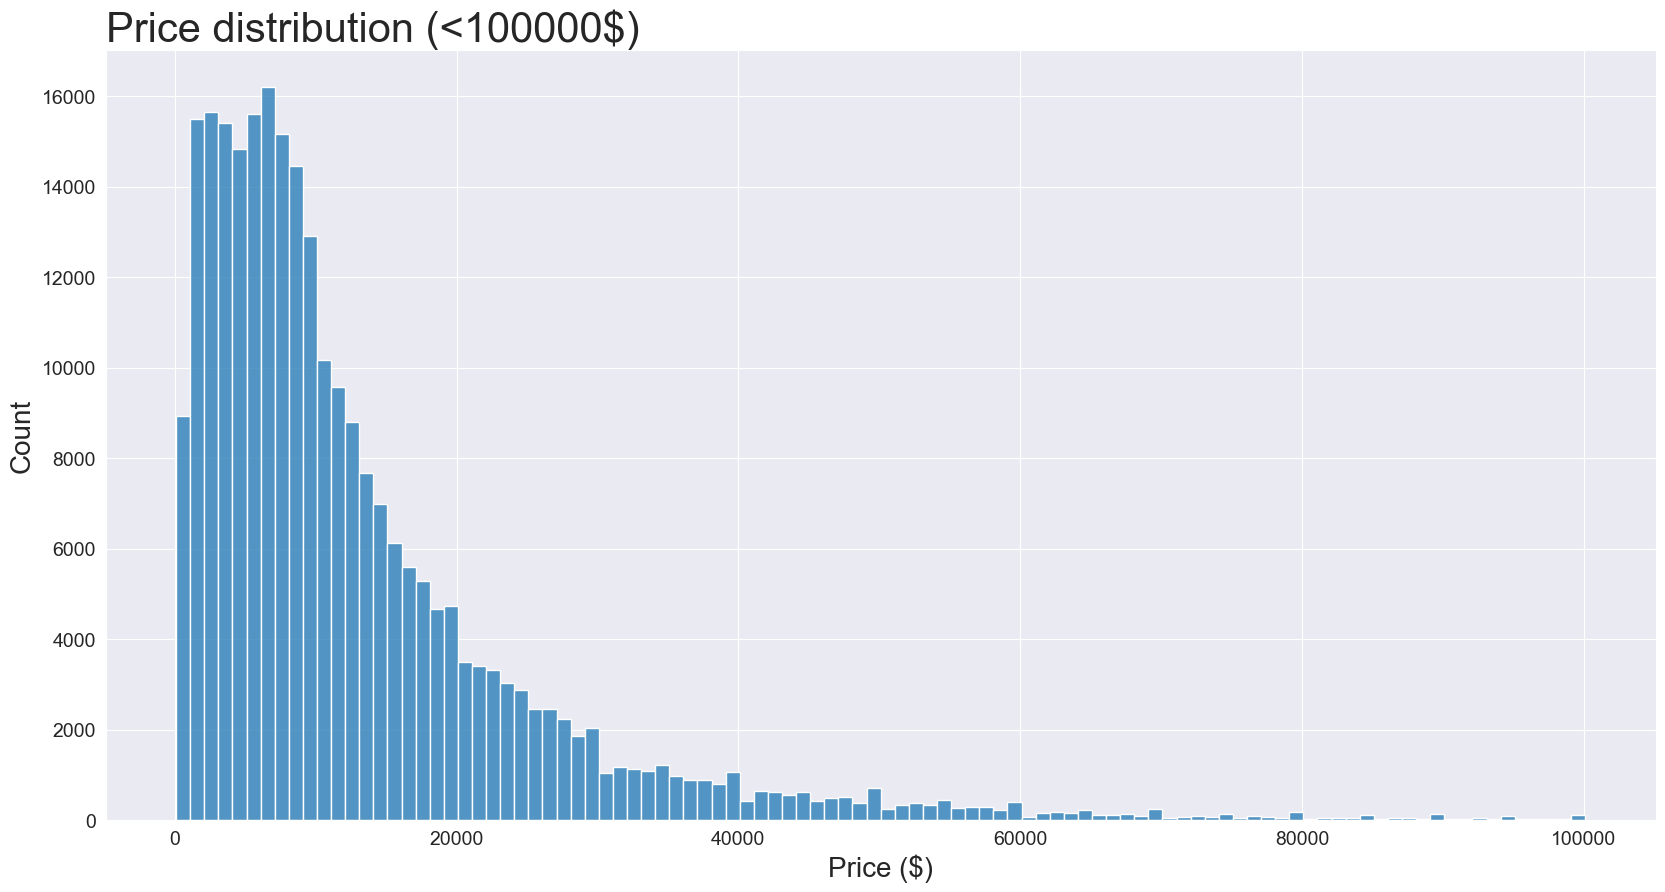

In [4]:
plt.figure(figsize=(20, 10))
sns.histplot(data=cars[cars['price'] < 100000], x='price', binwidth=1000)
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
plt.xlabel('Price ($)', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Price distribution (<100000$)', fontsize=30, loc='left')
plt.show()

Seems like price distribution is right-skewed but let's check if it is normally distributed.

H0: Price is normally distributed.
H1: Price is not normally distributed.

Let's use Kolmogorov-Smirnov test.

In [5]:
kstest(cars['price'].dropna(), 'norm')

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=100.0, statistic_sign=-1)

P-value is smaller than 0.05, so we reject null hypothesis.
This data in not normally distributed.

## Data relationships

For numerical columns let's use Kendall correlation.
- `price` is not normally distributed, so we can't use Pearson correlation
- some columns (e.g. `price` and `reg_year`) are not monotonically related se we can't use Spearman correlation 

In [6]:
cars.corr(method='kendall', numeric_only=True)['price'].sort_values(ascending=False)

log_price       1.000000
price           1.000000
reg_year        0.566539
engine_power    0.416704
length          0.333347
top_speed       0.325650
engine_size     0.309024
width           0.306246
wheelbase       0.304577
height          0.115445
adv_year        0.108066
seat_num        0.032212
average_mpg     0.023576
door_num        0.019635
annual_tax     -0.003239
adv_month      -0.057320
run_miles      -0.472960
Name: price, dtype: float64

For categorical columns let's use ANOVA (should only be used for normally distributed data, but we will use it for the purpose of this exercise) and Kruskal-Wallis test.

In [7]:
categorical_columns = ['maker', 'genmodel', 'color', 'body_type', 'gearbox', 'fuel_type']

for column in categorical_columns:
    model = ols(formula=f'price  ~ {column}', data=cars).fit()

    anova_result = sm.stats.anova_lm(model, type=2)
    print(anova_result)

                df        sum_sq       mean_sq            F  PR(>F)
maker         87.0  8.013620e+13  9.211058e+11  2474.299306     0.0
Residual  266147.0  9.907837e+13  3.722693e+08          NaN     NaN
                df        sum_sq       mean_sq            F  PR(>F)
genmodel     889.0  1.496804e+14  1.683694e+11  1512.687401     0.0
Residual  265345.0  2.953418e+13  1.113048e+08          NaN     NaN
                df        sum_sq       mean_sq          F  PR(>F)
color         21.0  1.386221e+12  6.601052e+10  99.400097     0.0
Residual  244476.0  1.623539e+14  6.640891e+08        NaN     NaN
                 df        sum_sq       mean_sq            F  PR(>F)
body_type      16.0  1.743328e+13  1.089580e+12  1823.020906     0.0
Residual   266199.0  1.591013e+14  5.976782e+08          NaN     NaN
                df        sum_sq       mean_sq            F  PR(>F)
gearbox        2.0  1.806156e+13  9.030781e+12  17900.11293     0.0
Residual  266082.0  1.342410e+14  5.045097e+08     

In [8]:
categorical_columns = ['maker', 'genmodel', 'color', 'body_type', 'gearbox', 'fuel_type']

for column in categorical_columns:
    grouped_data = cars.groupby(column)['price'].apply(list)

    kruskal_results = kruskal(*grouped_data)
    print(f'{column}: {kruskal_results}')

maker: KruskalResult(statistic=73275.87077641764, pvalue=0.0)
genmodel: KruskalResult(statistic=165688.46954589905, pvalue=0.0)
color: KruskalResult(statistic=10361.527509947071, pvalue=0.0)
body_type: KruskalResult(statistic=62417.167725295396, pvalue=0.0)
gearbox: KruskalResult(statistic=61354.43226571896, pvalue=0.0)
fuel_type: KruskalResult(statistic=17437.746359662422, pvalue=0.0)


Most related columns:
- numerical: `req_year`, `engine_power`, `run_miles`
- categorical: `maker`, `genmodel`, `color`, `body_type`, `gearbox`, `fuel_type` (further visualizations are needed to draw conclusions)

## Visualizations

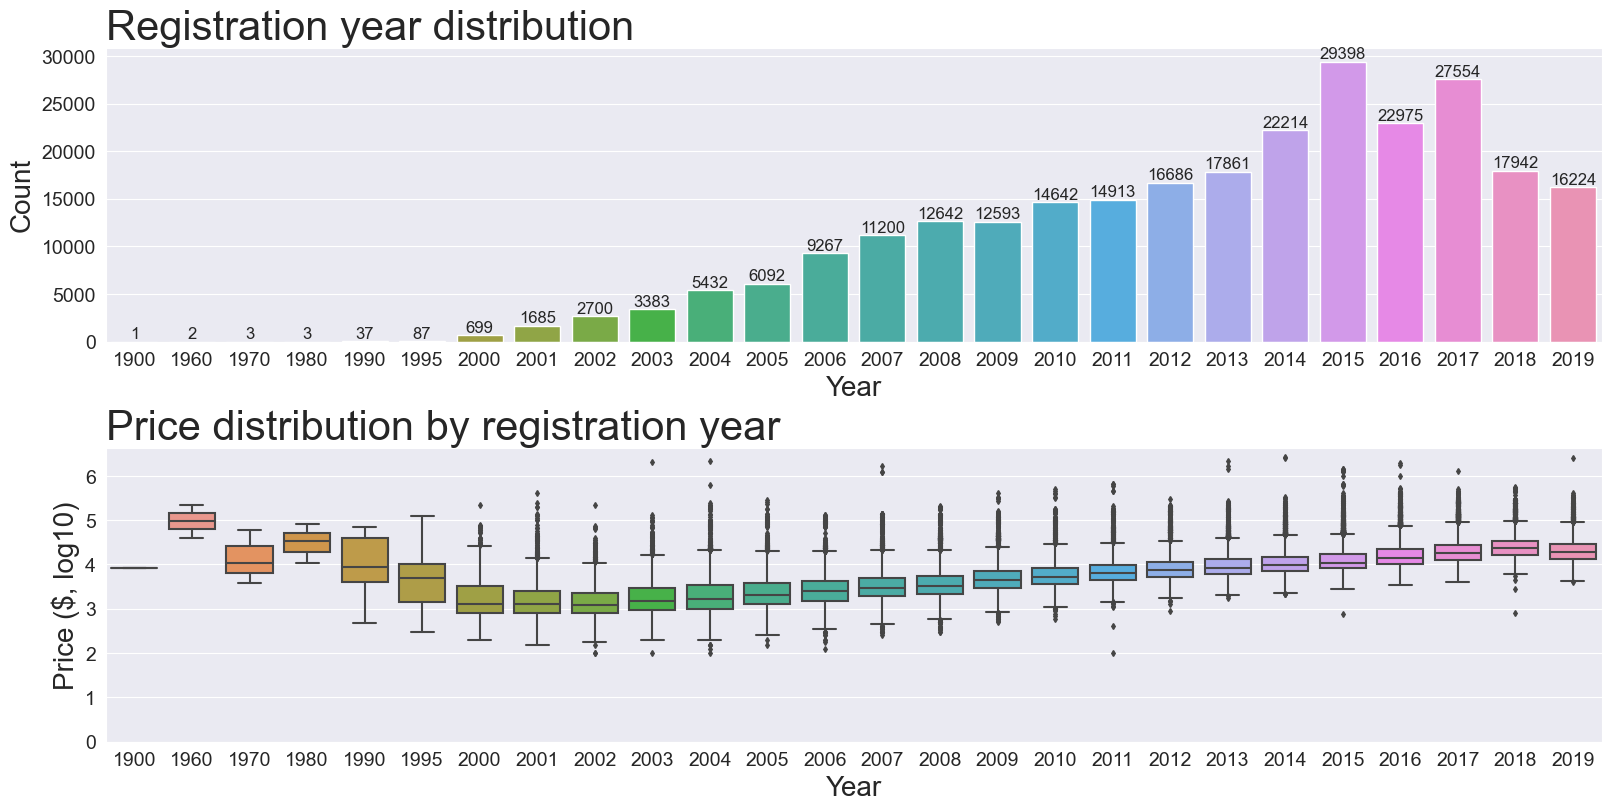

In [9]:
_, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(16, 8), layout='constrained')

sns.countplot(data=cars, x='reg_year', orient='v', ax=ax0)
ax0.set_title('Registration year distribution', fontdict={'fontsize': 30}, loc='left')
ax0.set_xlabel('Year', fontdict={'fontsize': 20})
ax0.set_ylabel('Count', fontdict={'fontsize': 20})
ax0.tick_params(axis='both', which='major', labelsize=14)
ax0.bar_label(ax0.containers[0], fontsize=12)

sns.boxplot(data=cars, x='reg_year', y='log_price', fliersize=3, ax=ax1)
ax1.set_title('Price distribution by registration year', fontdict={'fontsize': 30}, loc='left')
ax1.set_xlabel('Year', fontdict={'fontsize': 20})
ax1.set_ylabel('Price ($, log10)', fontdict={'fontsize': 20})
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_ylim(ymin=0)

plt.show()

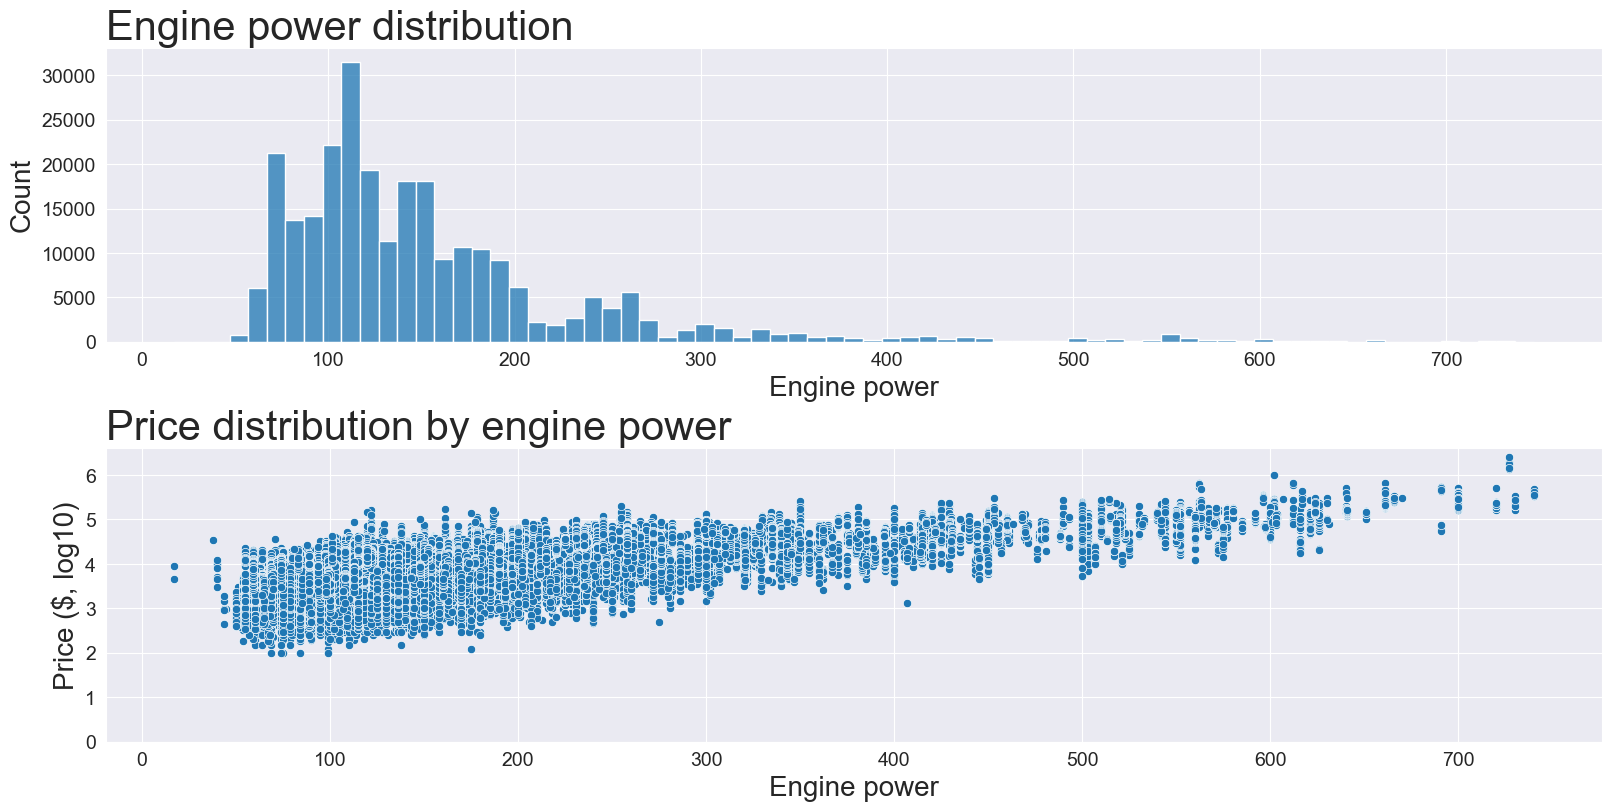

In [10]:
_, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(16, 8), layout='constrained')

sns.histplot(data=cars, x='engine_power', binwidth=10, ax=ax0)
ax0.set_title('Engine power distribution', fontdict={'fontsize': 30}, loc='left')
ax0.set_xlabel('Engine power', fontdict={'fontsize': 20})
ax0.set_ylabel('Count', fontdict={'fontsize': 20})
ax0.tick_params(axis='both', which='major', labelsize=14)

sns.scatterplot(data=cars, x='engine_power', y='log_price')
ax1.set_title('Price distribution by engine power', fontdict={'fontsize': 30}, loc='left')
ax1.set_xlabel('Engine power', fontdict={'fontsize': 20})
ax1.set_ylabel('Price ($, log10)', fontdict={'fontsize': 20})
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_ylim(ymin=0)

plt.show()

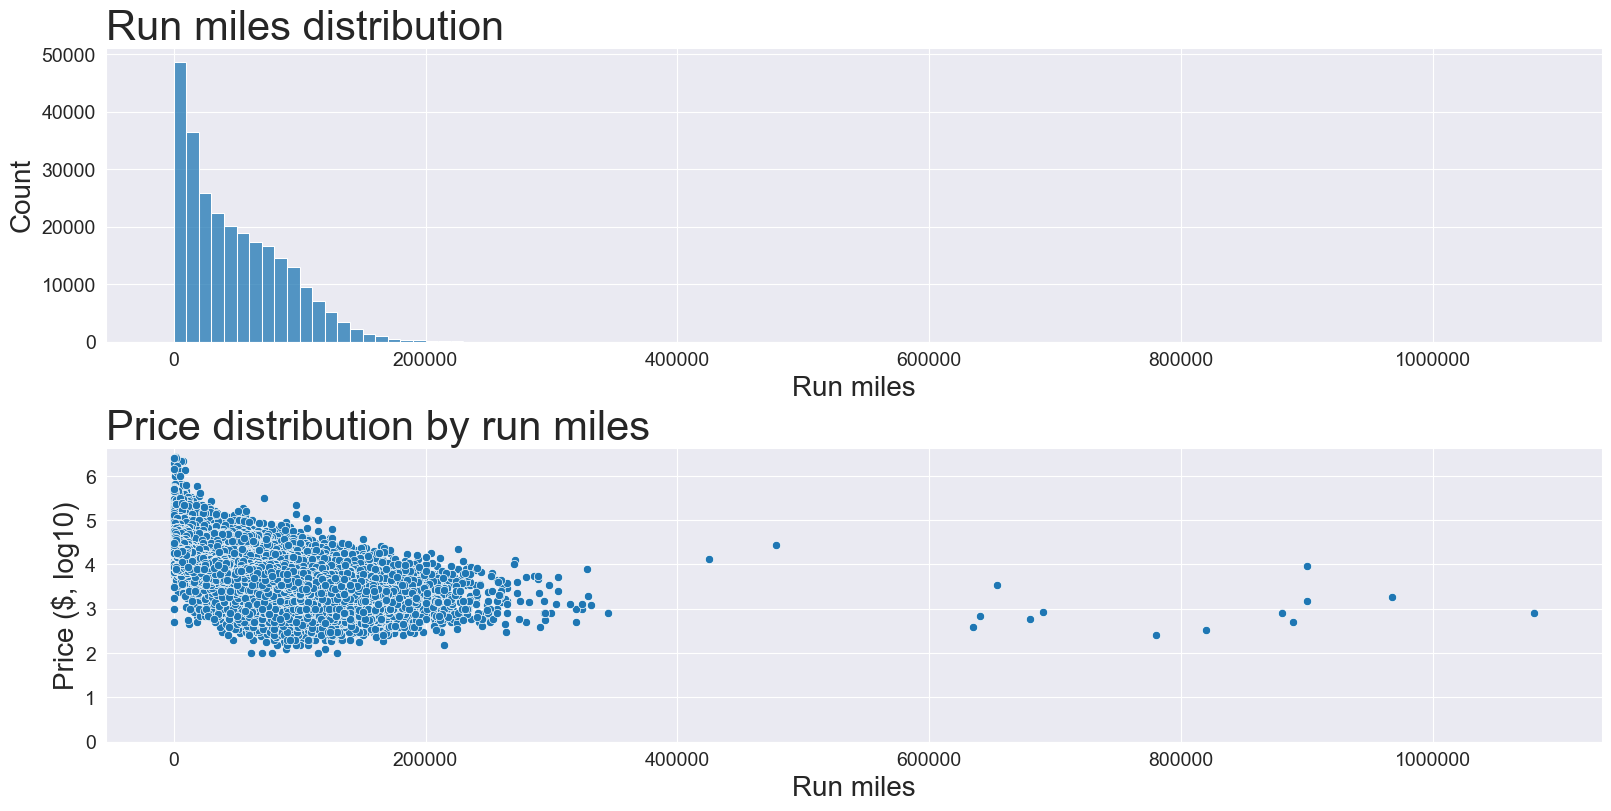

In [11]:
_, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(16, 8), layout='constrained')

sns.histplot(data=cars, x='run_miles', binwidth=10000, ax=ax0)
ax0.set_title('Run miles distribution', fontdict={'fontsize': 30}, loc='left')
ax0.set_xlabel('Run miles', fontdict={'fontsize': 20})
ax0.set_ylabel('Count', fontdict={'fontsize': 20})
ax0.tick_params(axis='both', which='major', labelsize=14)
ax0.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

sns.scatterplot(data=cars, x='run_miles', y='log_price')
ax1.set_title('Price distribution by run miles', fontdict={'fontsize': 30}, loc='left')
ax1.set_xlabel('Run miles', fontdict={'fontsize': 20})
ax1.set_ylabel('Price ($, log10)', fontdict={'fontsize': 20})
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
ax1.set_ylim(ymin=0)

plt.show()

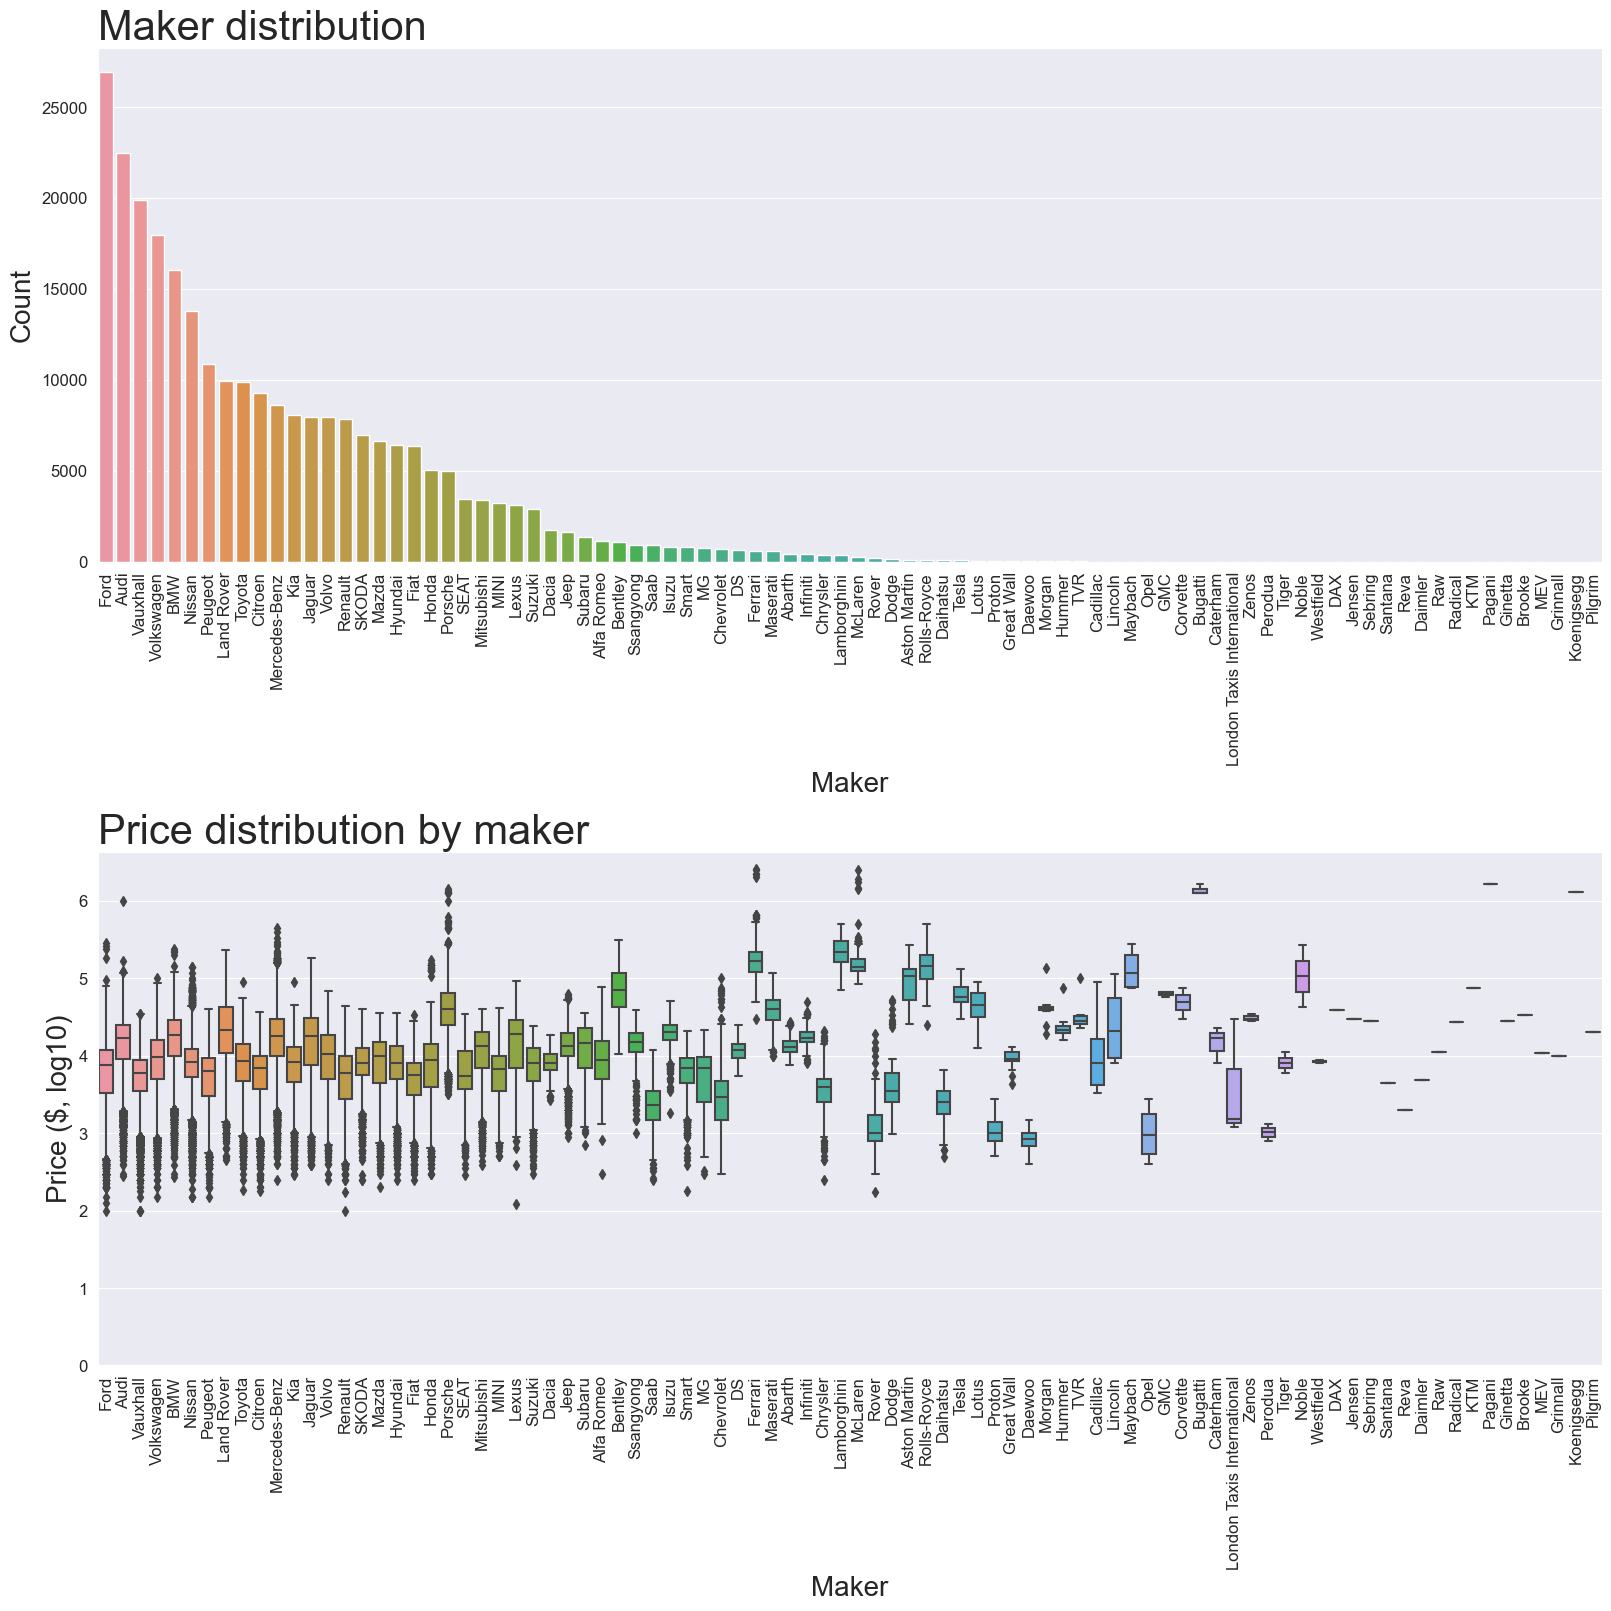

In [12]:
order = cars['maker'].value_counts().index

_, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(16, 16), layout='constrained')

sns.countplot(data=cars, x='maker', order=order, ax=ax0)
ax0.set_title('Maker distribution', fontdict={'fontsize': 30}, loc='left')
ax0.set_xlabel('Maker', fontdict={'fontsize': 20})
ax0.set_ylabel('Count', fontdict={'fontsize': 20})
ax0.tick_params(axis='both', which='major', labelsize=12)
ax0.tick_params(axis='x', rotation=90)

sns.boxplot(data=cars, x='maker', y='log_price', order=order, ax=ax1)
ax1.set_title('Price distribution by maker', fontdict={'fontsize': 30}, loc='left')
ax1.set_xlabel('Maker', fontdict={'fontsize': 20})
ax1.set_ylabel('Price ($, log10)', fontdict={'fontsize': 20})
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylim(ymin=0)

plt.show()

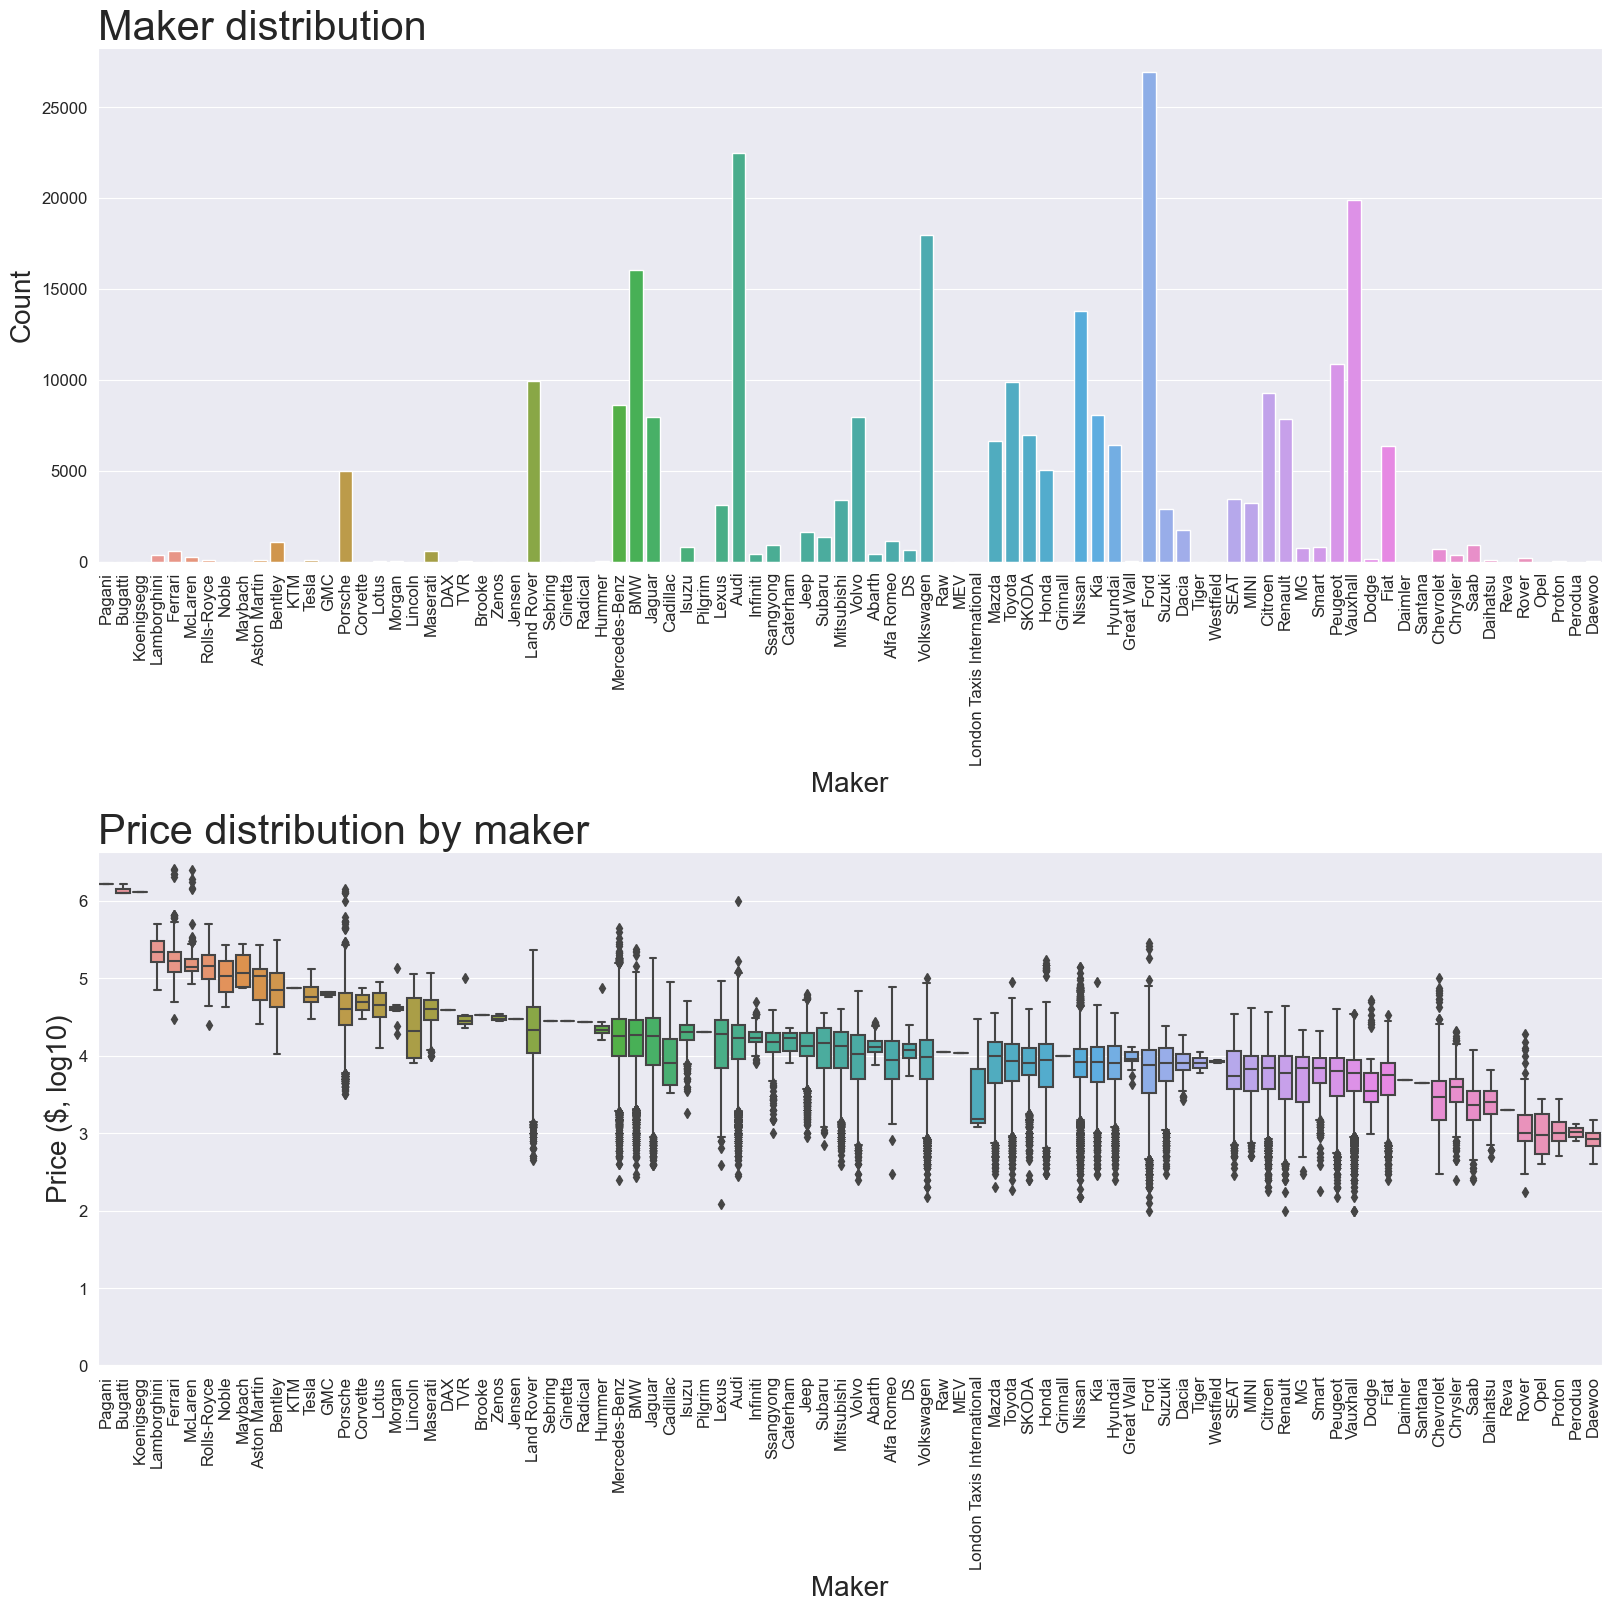

In [13]:
order = cars.groupby('maker')['price'].mean().sort_values(ascending=False).index

_, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(16, 16), layout='constrained')

sns.countplot(data=cars, x='maker', order=order, ax=ax0)
ax0.set_title('Maker distribution', fontdict={'fontsize': 30}, loc='left')
ax0.set_xlabel('Maker', fontdict={'fontsize': 20})
ax0.set_ylabel('Count', fontdict={'fontsize': 20})
ax0.tick_params(axis='both', which='major', labelsize=12)
ax0.tick_params(axis='x', rotation=90)

sns.boxplot(data=cars, x='maker', y='log_price', order=order, ax=ax1)
ax1.set_title('Price distribution by maker', fontdict={'fontsize': 30}, loc='left')
ax1.set_xlabel('Maker', fontdict={'fontsize': 20})
ax1.set_ylabel('Price ($, log10)', fontdict={'fontsize': 20})
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylim(ymin=0)

plt.show()

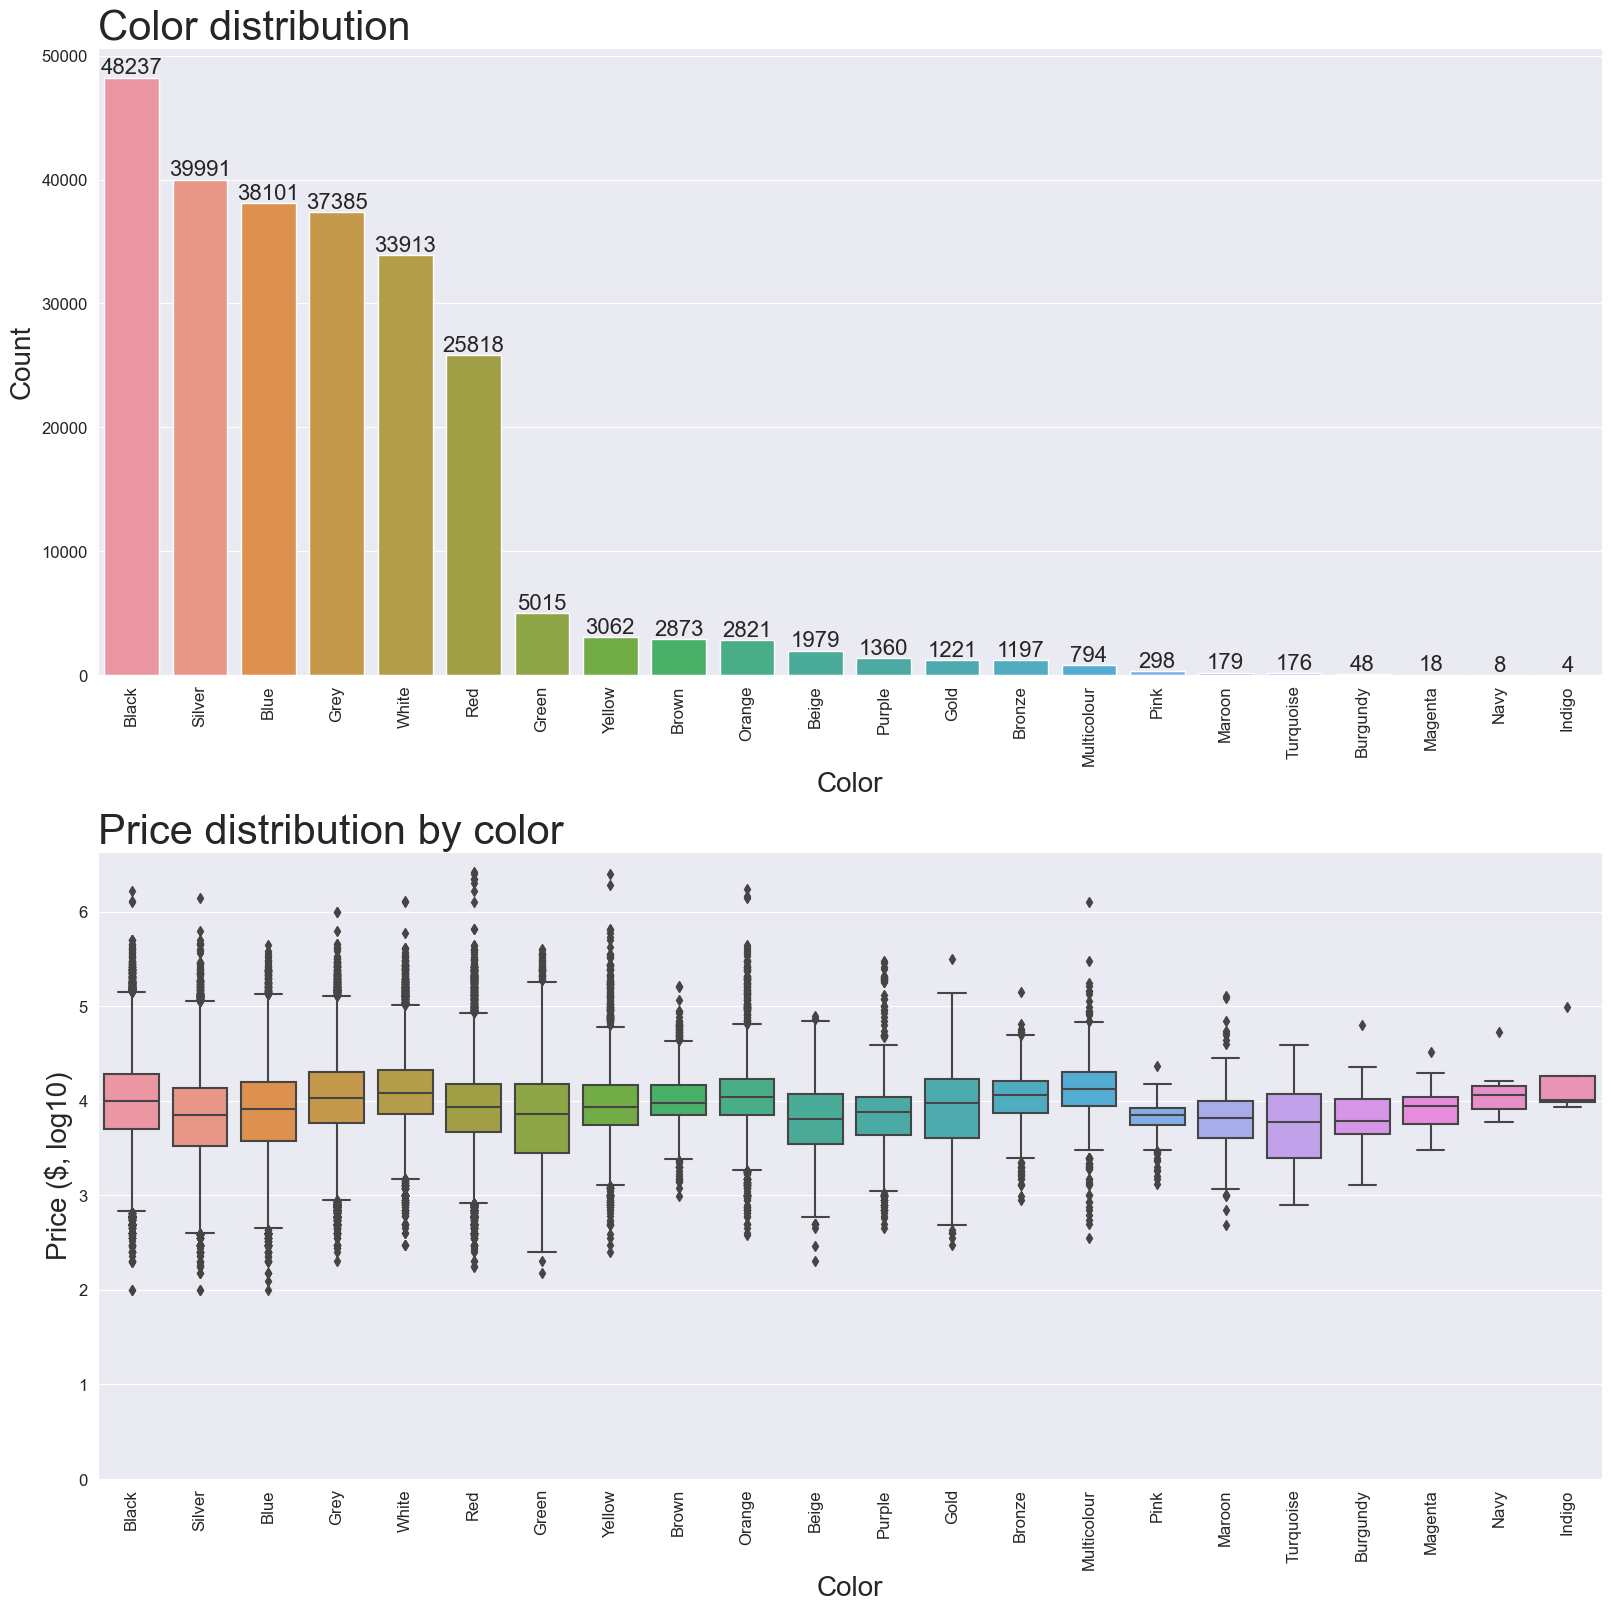

In [14]:
order = cars['color'].value_counts().index

_, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(16, 16), layout='constrained')

sns.countplot(data=cars, x='color', order=order, ax=ax0)
ax0.set_title('Color distribution', fontdict={'fontsize': 30}, loc='left')
ax0.set_xlabel('Color', fontdict={'fontsize': 20})
ax0.set_ylabel('Count', fontdict={'fontsize': 20})
ax0.tick_params(axis='both', which='major', labelsize=12)
ax0.tick_params(axis='x', rotation=90)
ax0.bar_label(ax0.containers[0], fontsize=16)

sns.boxplot(data=cars, x='color', y='log_price', order=order, ax=ax1)
ax1.set_title('Price distribution by color', fontdict={'fontsize': 30}, loc='left')
ax1.set_xlabel('Color', fontdict={'fontsize': 20})
ax1.set_ylabel('Price ($, log10)', fontdict={'fontsize': 20})
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylim(ymin=0)

plt.show()

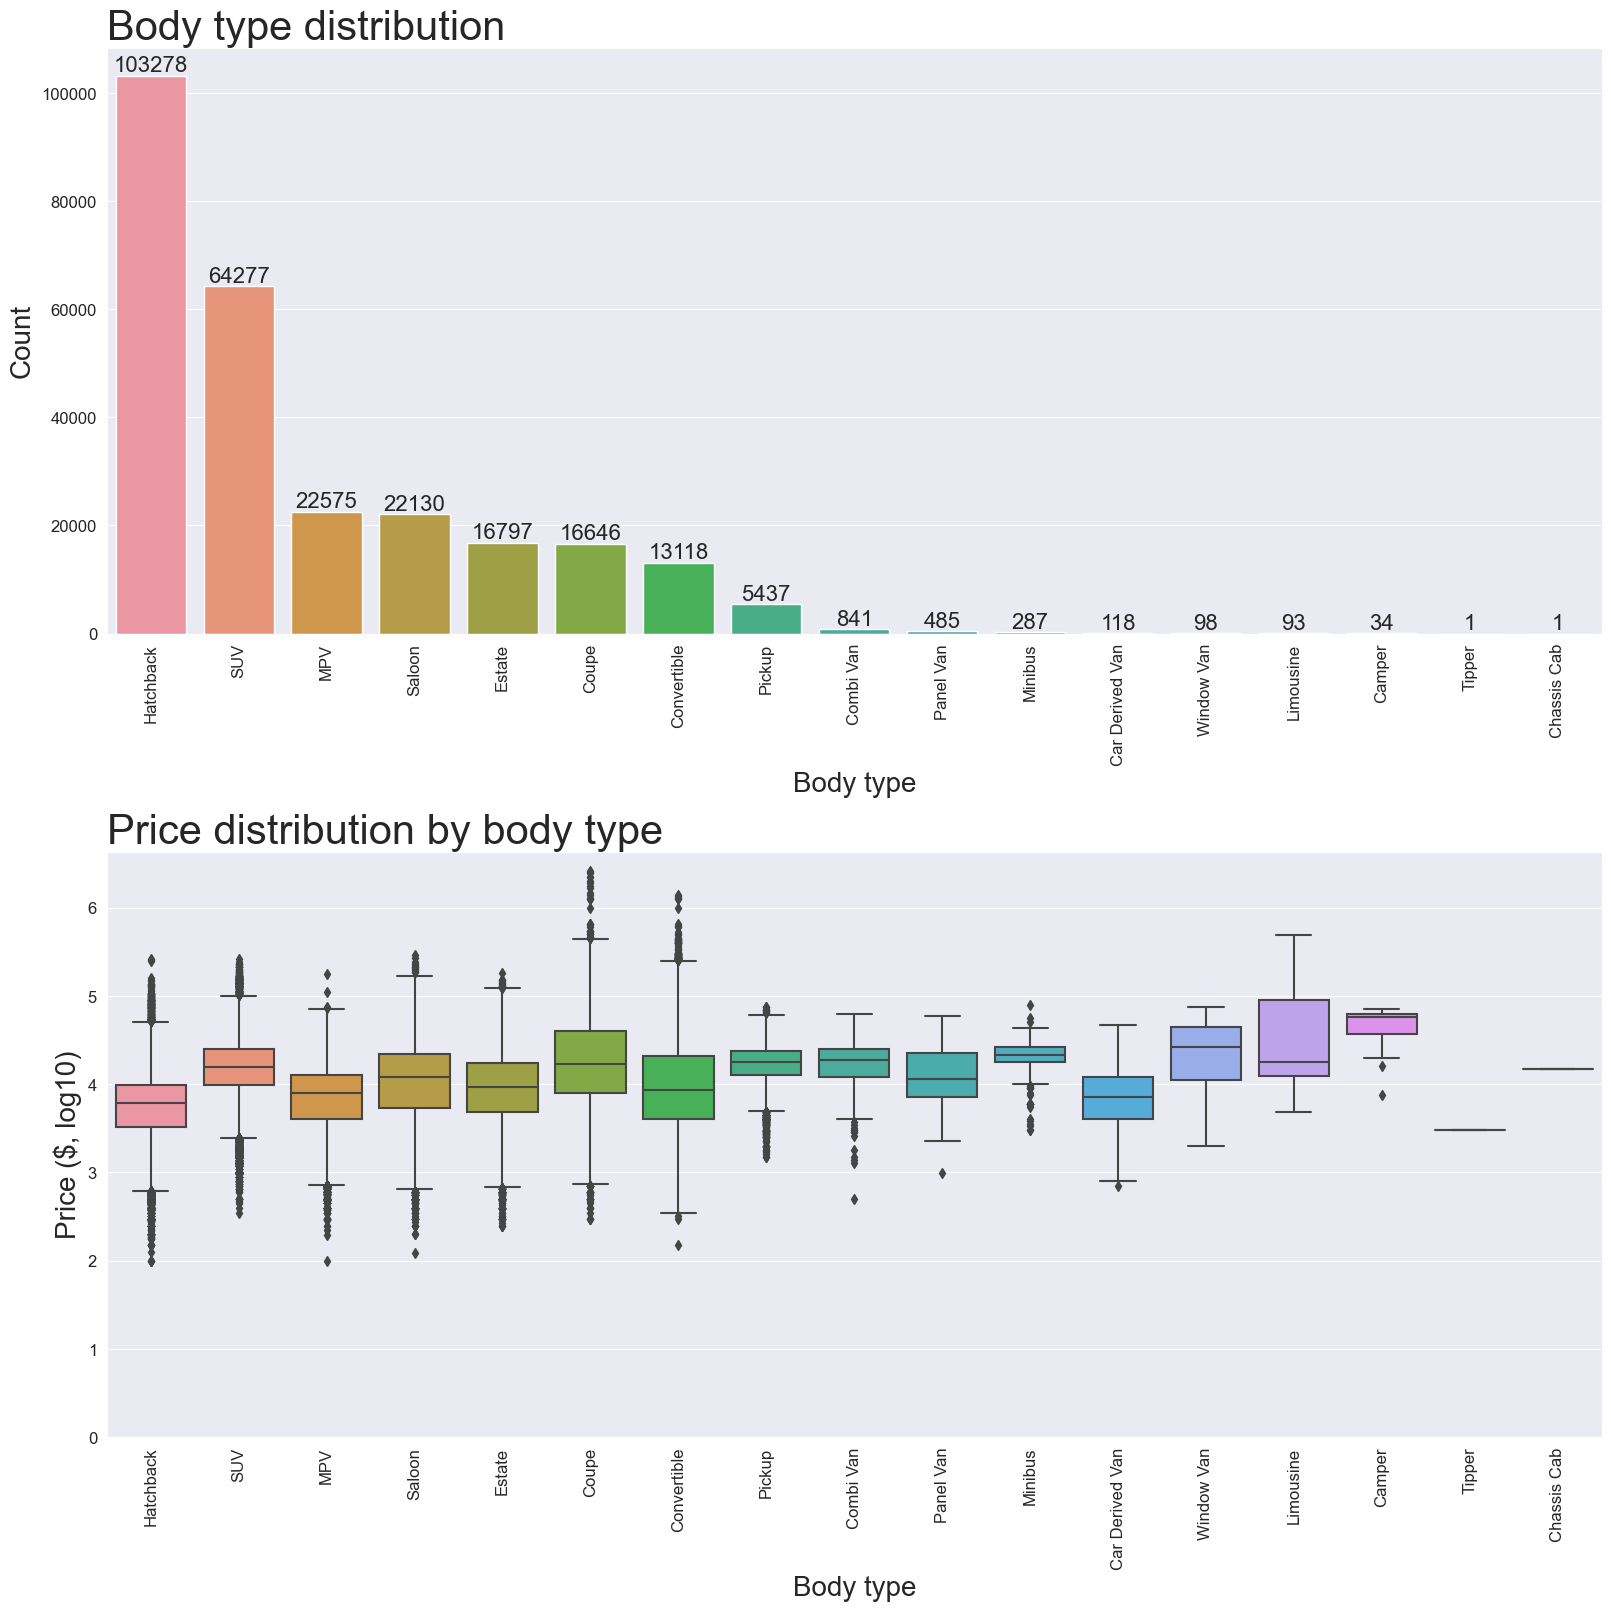

In [15]:
order = cars['body_type'].value_counts().index

_, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(16, 16), layout='constrained')

sns.countplot(data=cars, x='body_type', order=order, ax=ax0)
ax0.set_title('Body type distribution', fontdict={'fontsize': 30}, loc='left')
ax0.set_xlabel('Body type', fontdict={'fontsize': 20})
ax0.set_ylabel('Count', fontdict={'fontsize': 20})
ax0.tick_params(axis='both', which='major', labelsize=12)
ax0.tick_params(axis='x', rotation=90)
ax0.bar_label(ax0.containers[0], fontsize=16)

sns.boxplot(data=cars, x='body_type', y='log_price', order=order, ax=ax1)
ax1.set_title('Price distribution by body type', fontdict={'fontsize': 30}, loc='left')
ax1.set_xlabel('Body type', fontdict={'fontsize': 20})
ax1.set_ylabel('Price ($, log10)', fontdict={'fontsize': 20})
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylim(ymin=0)

plt.show()

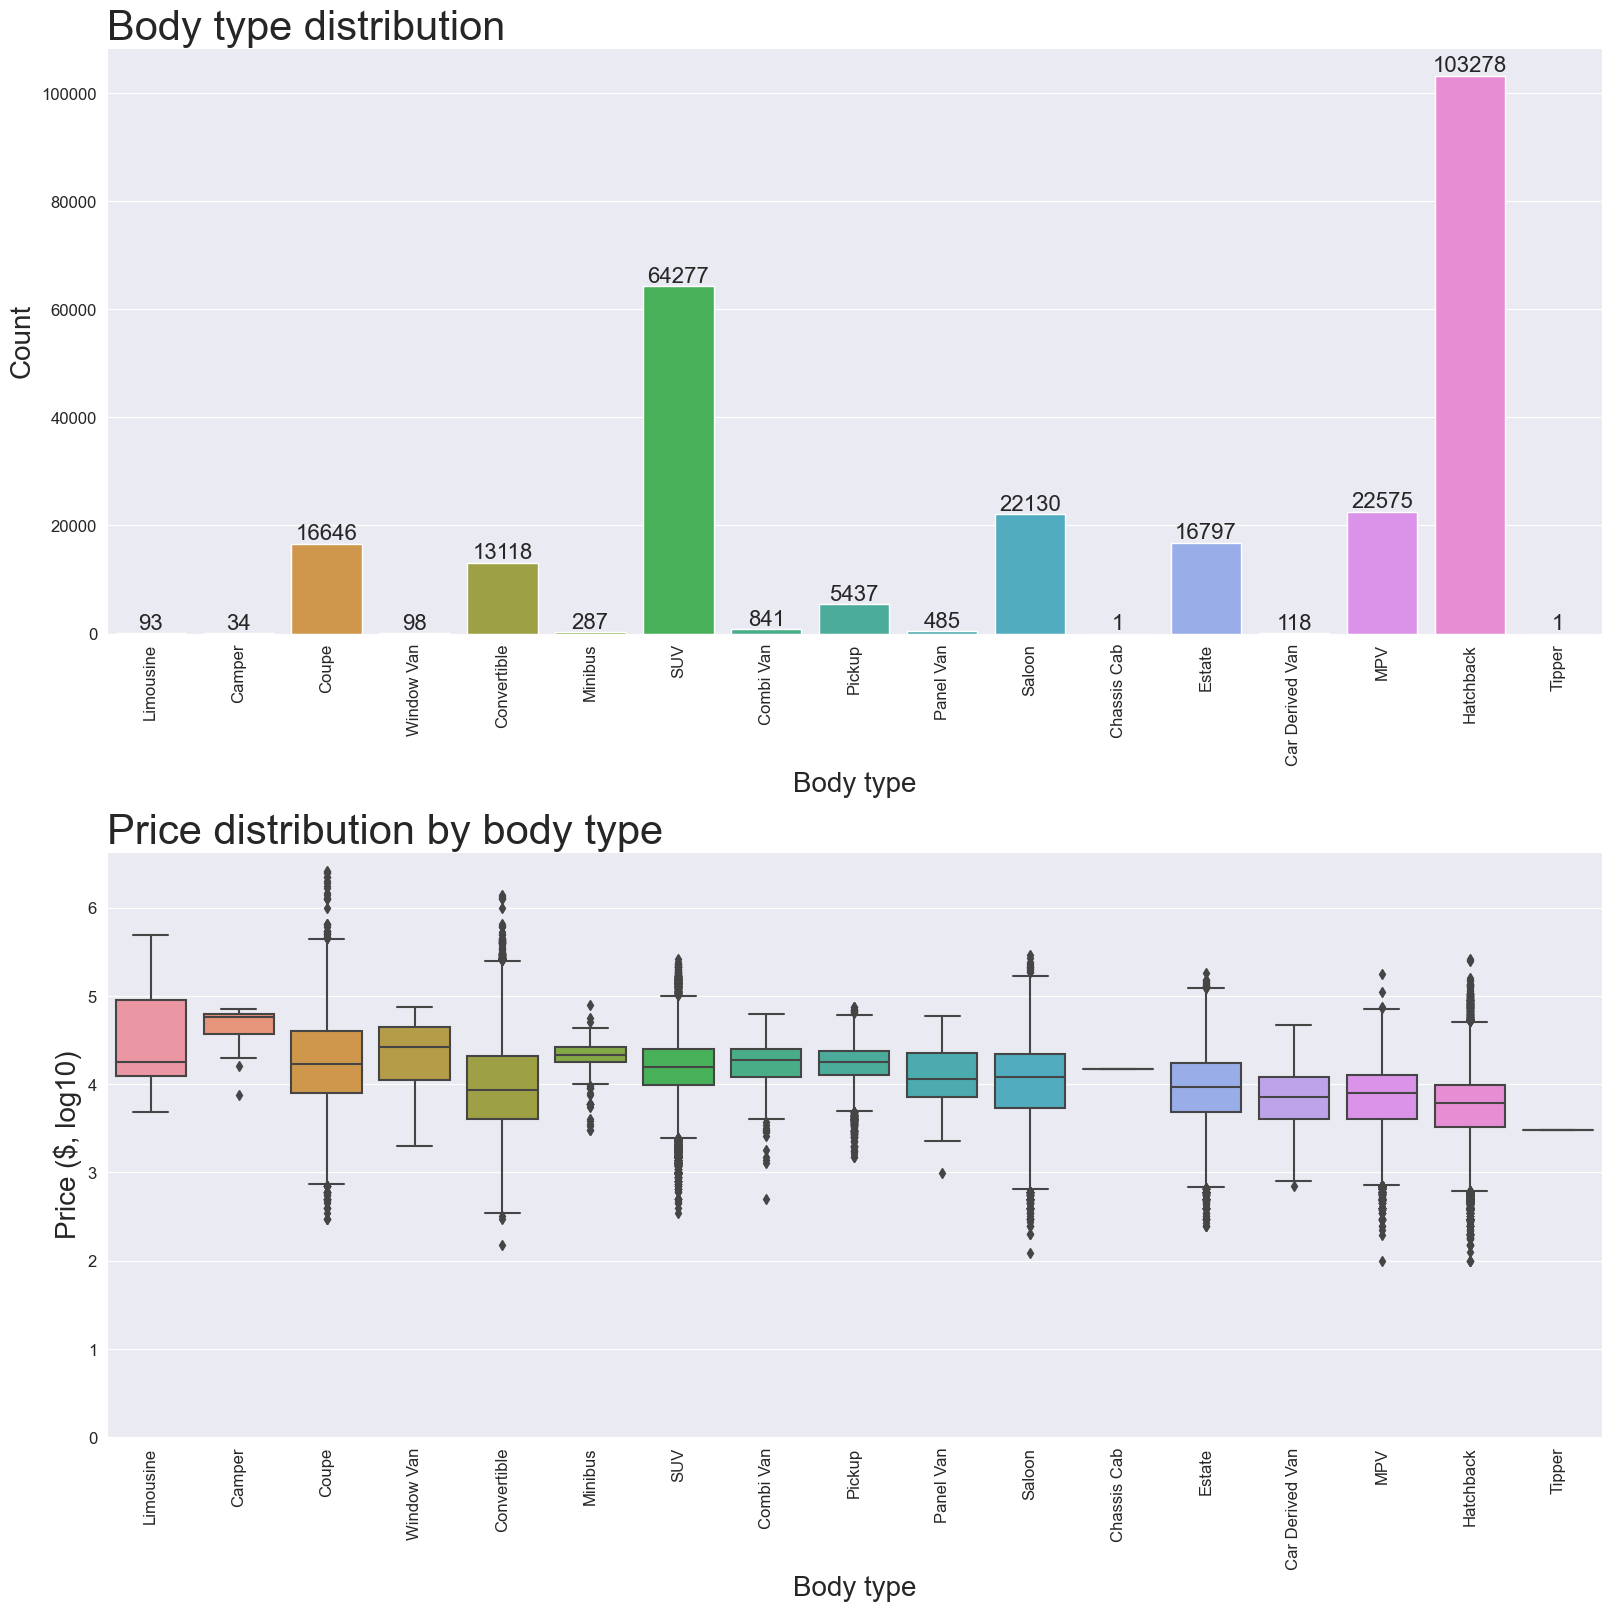

In [16]:
order = cars.groupby('body_type')['price'].mean().sort_values(ascending=False).index

_, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(16, 16), layout='constrained')

sns.countplot(data=cars, x='body_type', order=order, ax=ax0)
ax0.set_title('Body type distribution', fontdict={'fontsize': 30}, loc='left')
ax0.set_xlabel('Body type', fontdict={'fontsize': 20})
ax0.set_ylabel('Count', fontdict={'fontsize': 20})
ax0.tick_params(axis='both', which='major', labelsize=12)
ax0.tick_params(axis='x', rotation=90)
ax0.bar_label(ax0.containers[0], fontsize=16)

sns.boxplot(data=cars, x='body_type', y='log_price', order=order, ax=ax1)
ax1.set_title('Price distribution by body type', fontdict={'fontsize': 30}, loc='left')
ax1.set_xlabel('Body type', fontdict={'fontsize': 20})
ax1.set_ylabel('Price ($, log10)', fontdict={'fontsize': 20})
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylim(ymin=0)

plt.show()

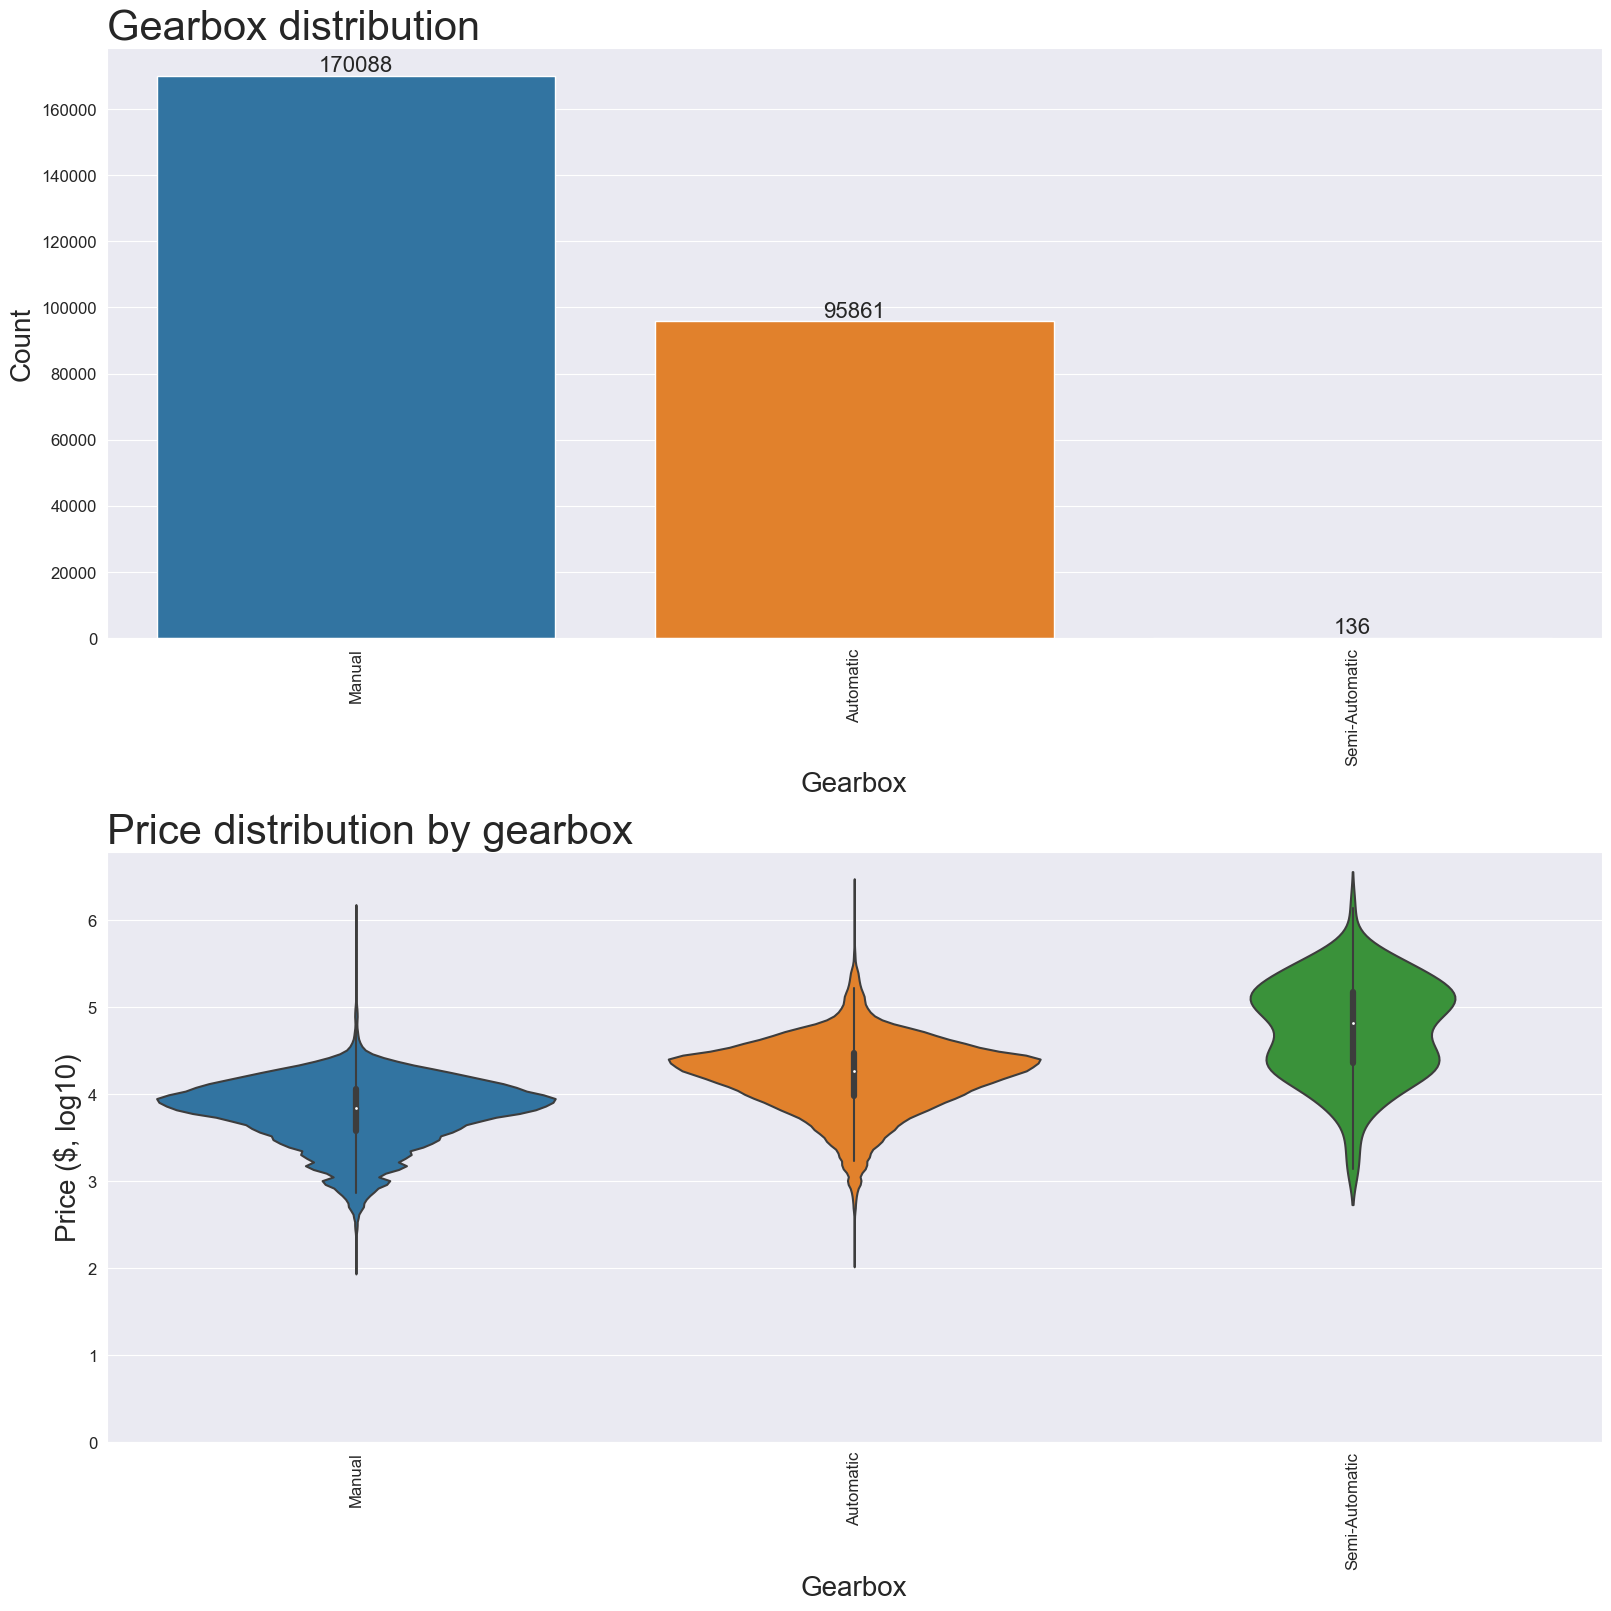

In [17]:
order = cars['gearbox'].value_counts().index

_, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(16, 16), layout='constrained')

sns.countplot(data=cars, x='gearbox', order=order, ax=ax0)
ax0.set_title('Gearbox distribution', fontdict={'fontsize': 30}, loc='left')
ax0.set_xlabel('Gearbox', fontdict={'fontsize': 20})
ax0.set_ylabel('Count', fontdict={'fontsize': 20})
ax0.tick_params(axis='both', which='major', labelsize=12)
ax0.tick_params(axis='x', rotation=90)
ax0.bar_label(ax0.containers[0], fontsize=16)

sns.violinplot(data=cars, x='gearbox', y='log_price', order=order, ax=ax1)
ax1.set_title('Price distribution by gearbox', fontdict={'fontsize': 30}, loc='left')
ax1.set_xlabel('Gearbox', fontdict={'fontsize': 20})
ax1.set_ylabel('Price ($, log10)', fontdict={'fontsize': 20})
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylim(ymin=0)

plt.show()

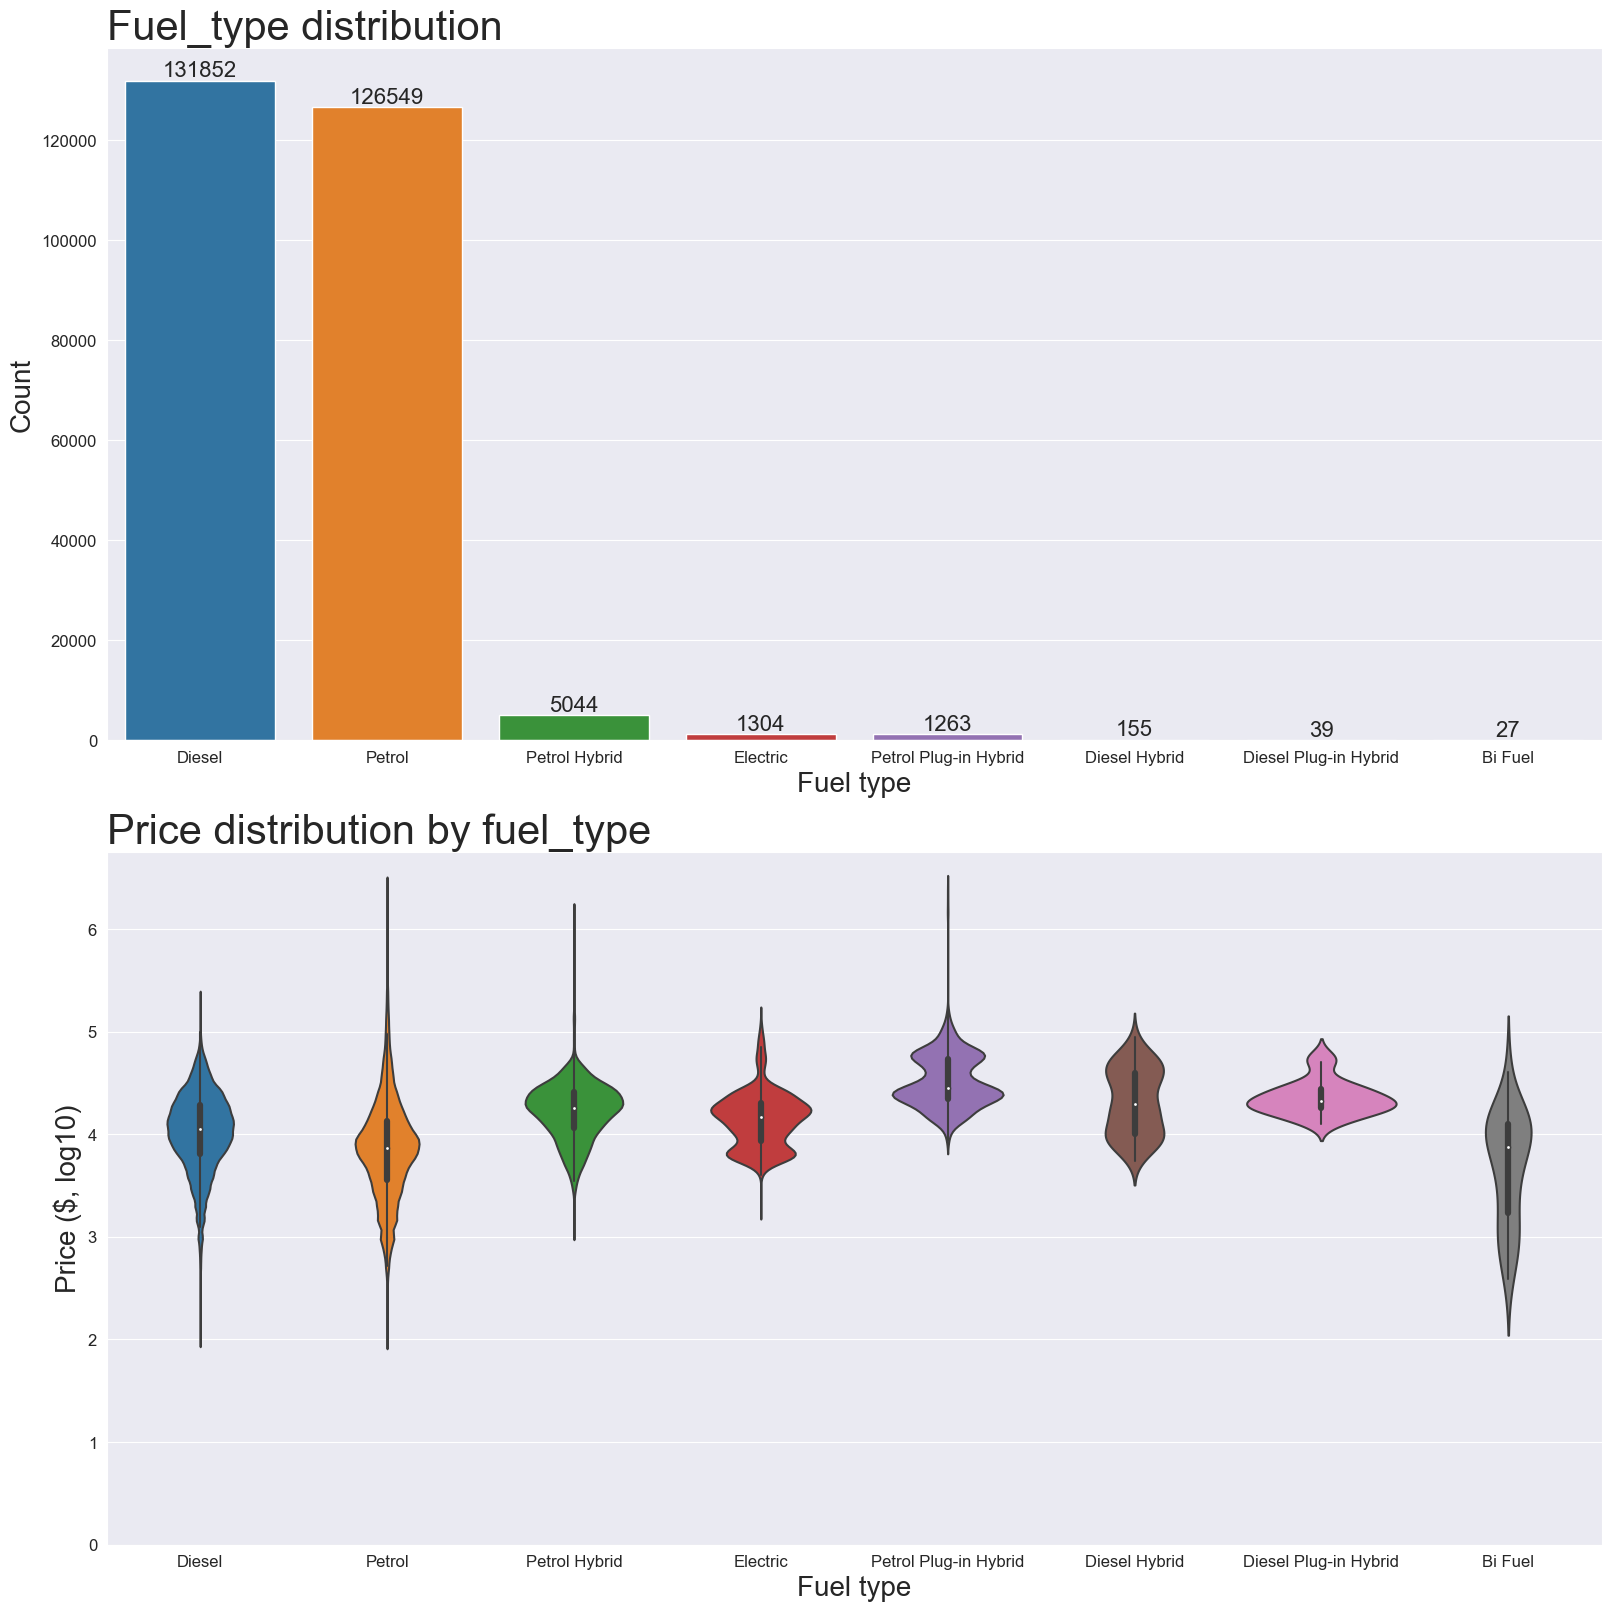

In [18]:
order = cars['fuel_type'].value_counts().index

_, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(16, 16), layout='constrained')

sns.countplot(data=cars, x='fuel_type', order=order, ax=ax0)
ax0.set_title('Fuel_type distribution', fontdict={'fontsize': 30}, loc='left')
ax0.set_xlabel('Fuel type', fontdict={'fontsize': 20})
ax0.set_ylabel('Count', fontdict={'fontsize': 20})
ax0.tick_params(axis='both', which='major', labelsize=12)
ax0.bar_label(ax0.containers[0], fontsize=16)

sns.violinplot(data=cars, x='fuel_type', y='log_price', order=order, ax=ax1)
ax1.set_title('Price distribution by fuel_type', fontdict={'fontsize': 30}, loc='left')
ax1.set_xlabel('Fuel type', fontdict={'fontsize': 20})
ax1.set_ylabel('Price ($, log10)', fontdict={'fontsize': 20})
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_ylim(ymin=0)

plt.show()

# Summary

5 Most important features:
- registration year
- engine power
- milage
- gearbox
- manufacturer

Honorable mentions:
- fuel type
- body type

Unexplored:
- model

# Bonus

In [19]:
cheap_cars = cars[cars['price'] < 50000]
expensive_cars = cars[cars['price'] >= 50000]

print(f'cheap cars: {len(cheap_cars)}')
print(f'expensive cars: {len(expensive_cars)}')

cheap cars: 257175
expensive cars: 9060


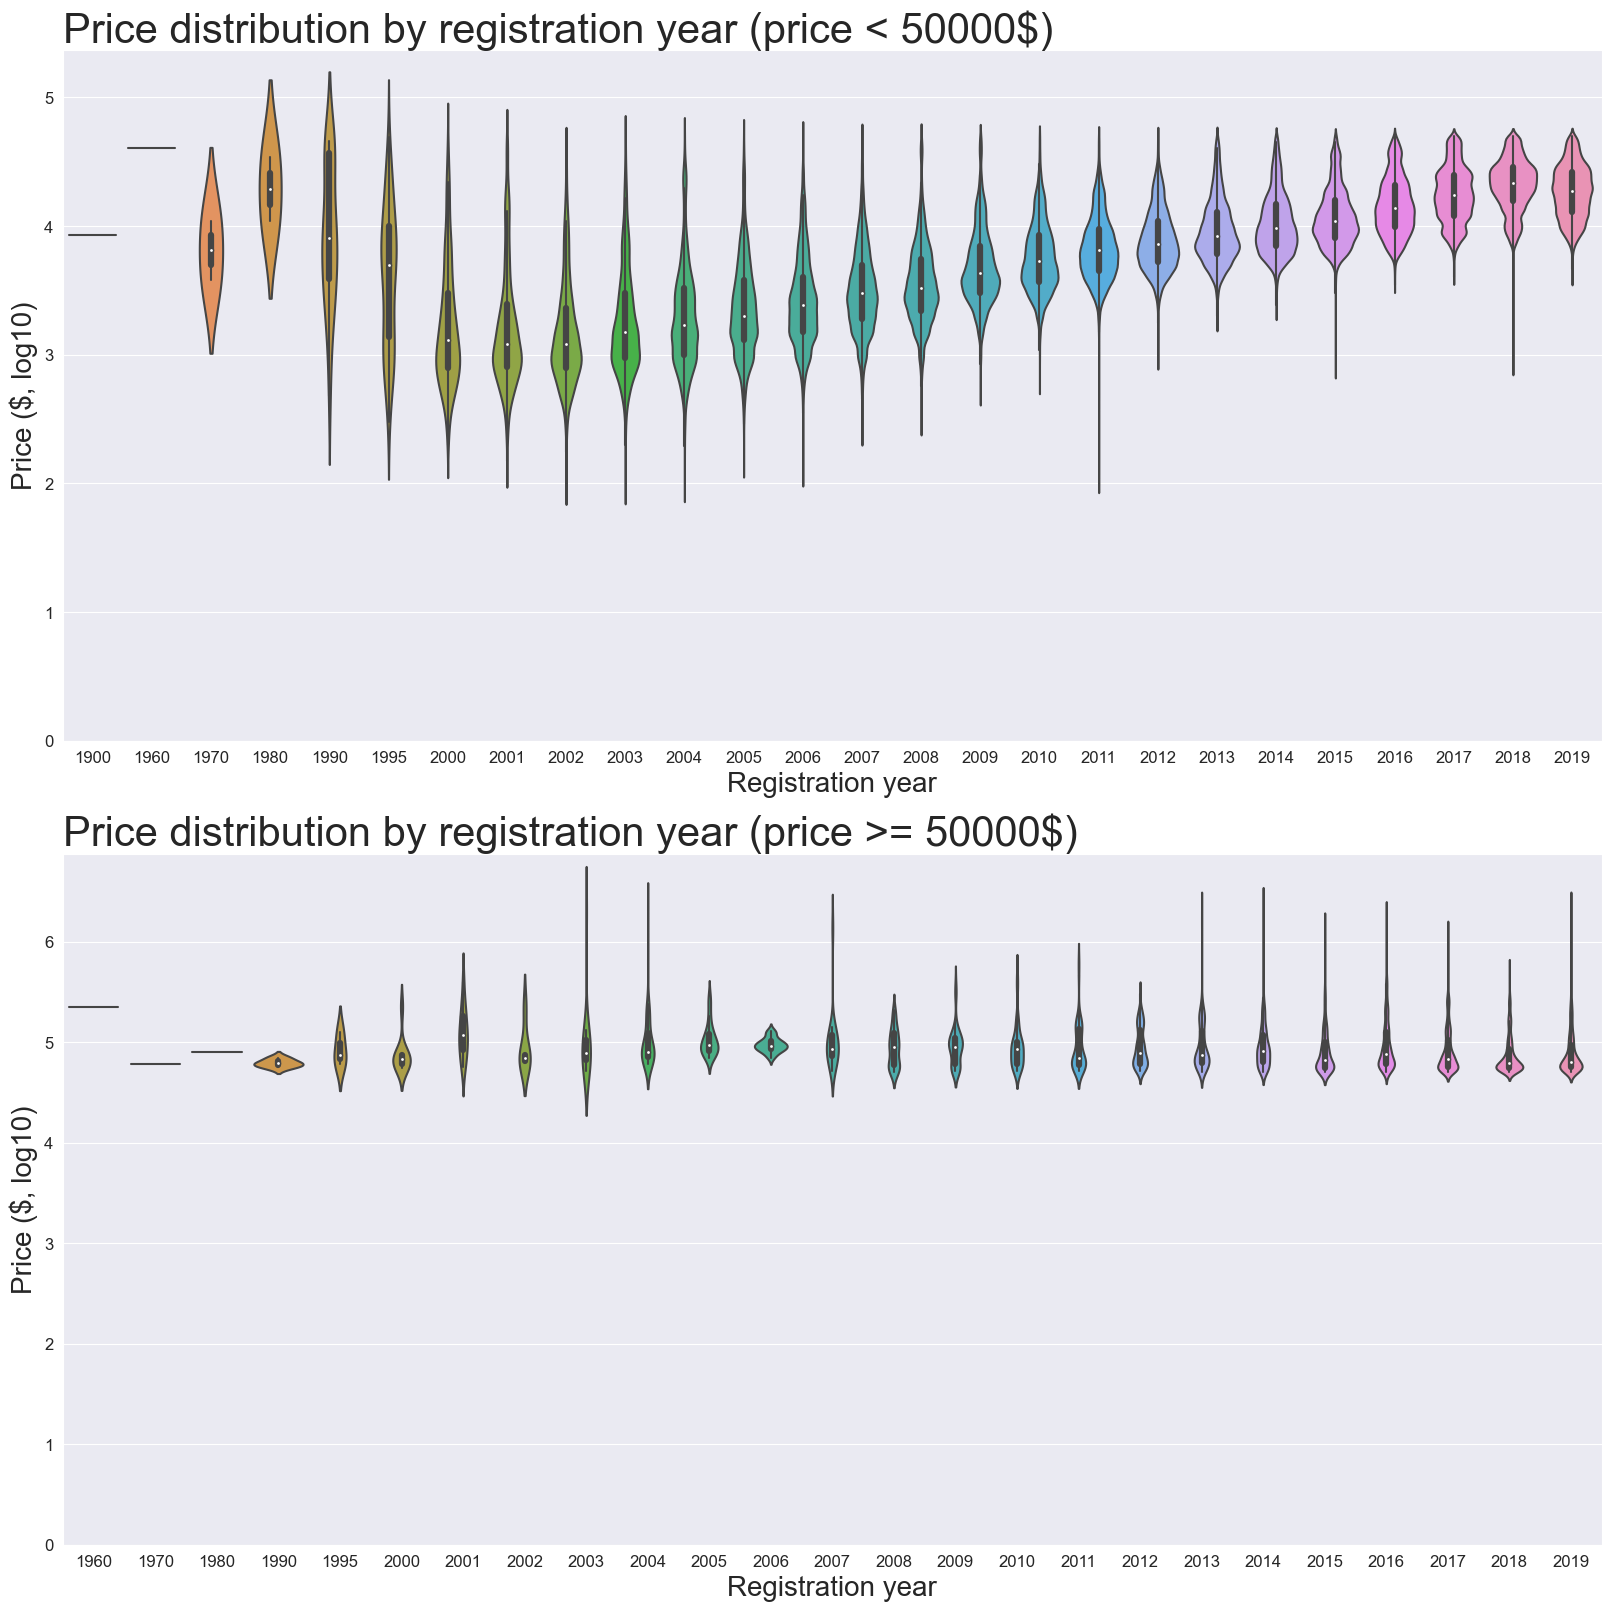

In [20]:
_, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(16, 16), layout='constrained')

sns.violinplot(data=cheap_cars, x='reg_year', y='log_price', ax=ax0)
ax0.set_title('Price distribution by registration year (price < 50000$)', fontdict={'fontsize': 30}, loc='left')
ax0.set_xlabel('Registration year', fontdict={'fontsize': 20})
ax0.set_ylabel('Price ($, log10)', fontdict={'fontsize': 20})
ax0.tick_params(axis='both', which='major', labelsize=12)
ax0.set_ylim(ymin=0)

sns.violinplot(data=expensive_cars, x='reg_year', y='log_price', ax=ax1)
ax1.set_title('Price distribution by registration year (price >= 50000$)', fontdict={'fontsize': 30}, loc='left')
ax1.set_xlabel('Registration year', fontdict={'fontsize': 20})
ax1.set_ylabel('Price ($, log10)', fontdict={'fontsize': 20})
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_ylim(ymin=0)

plt.show()

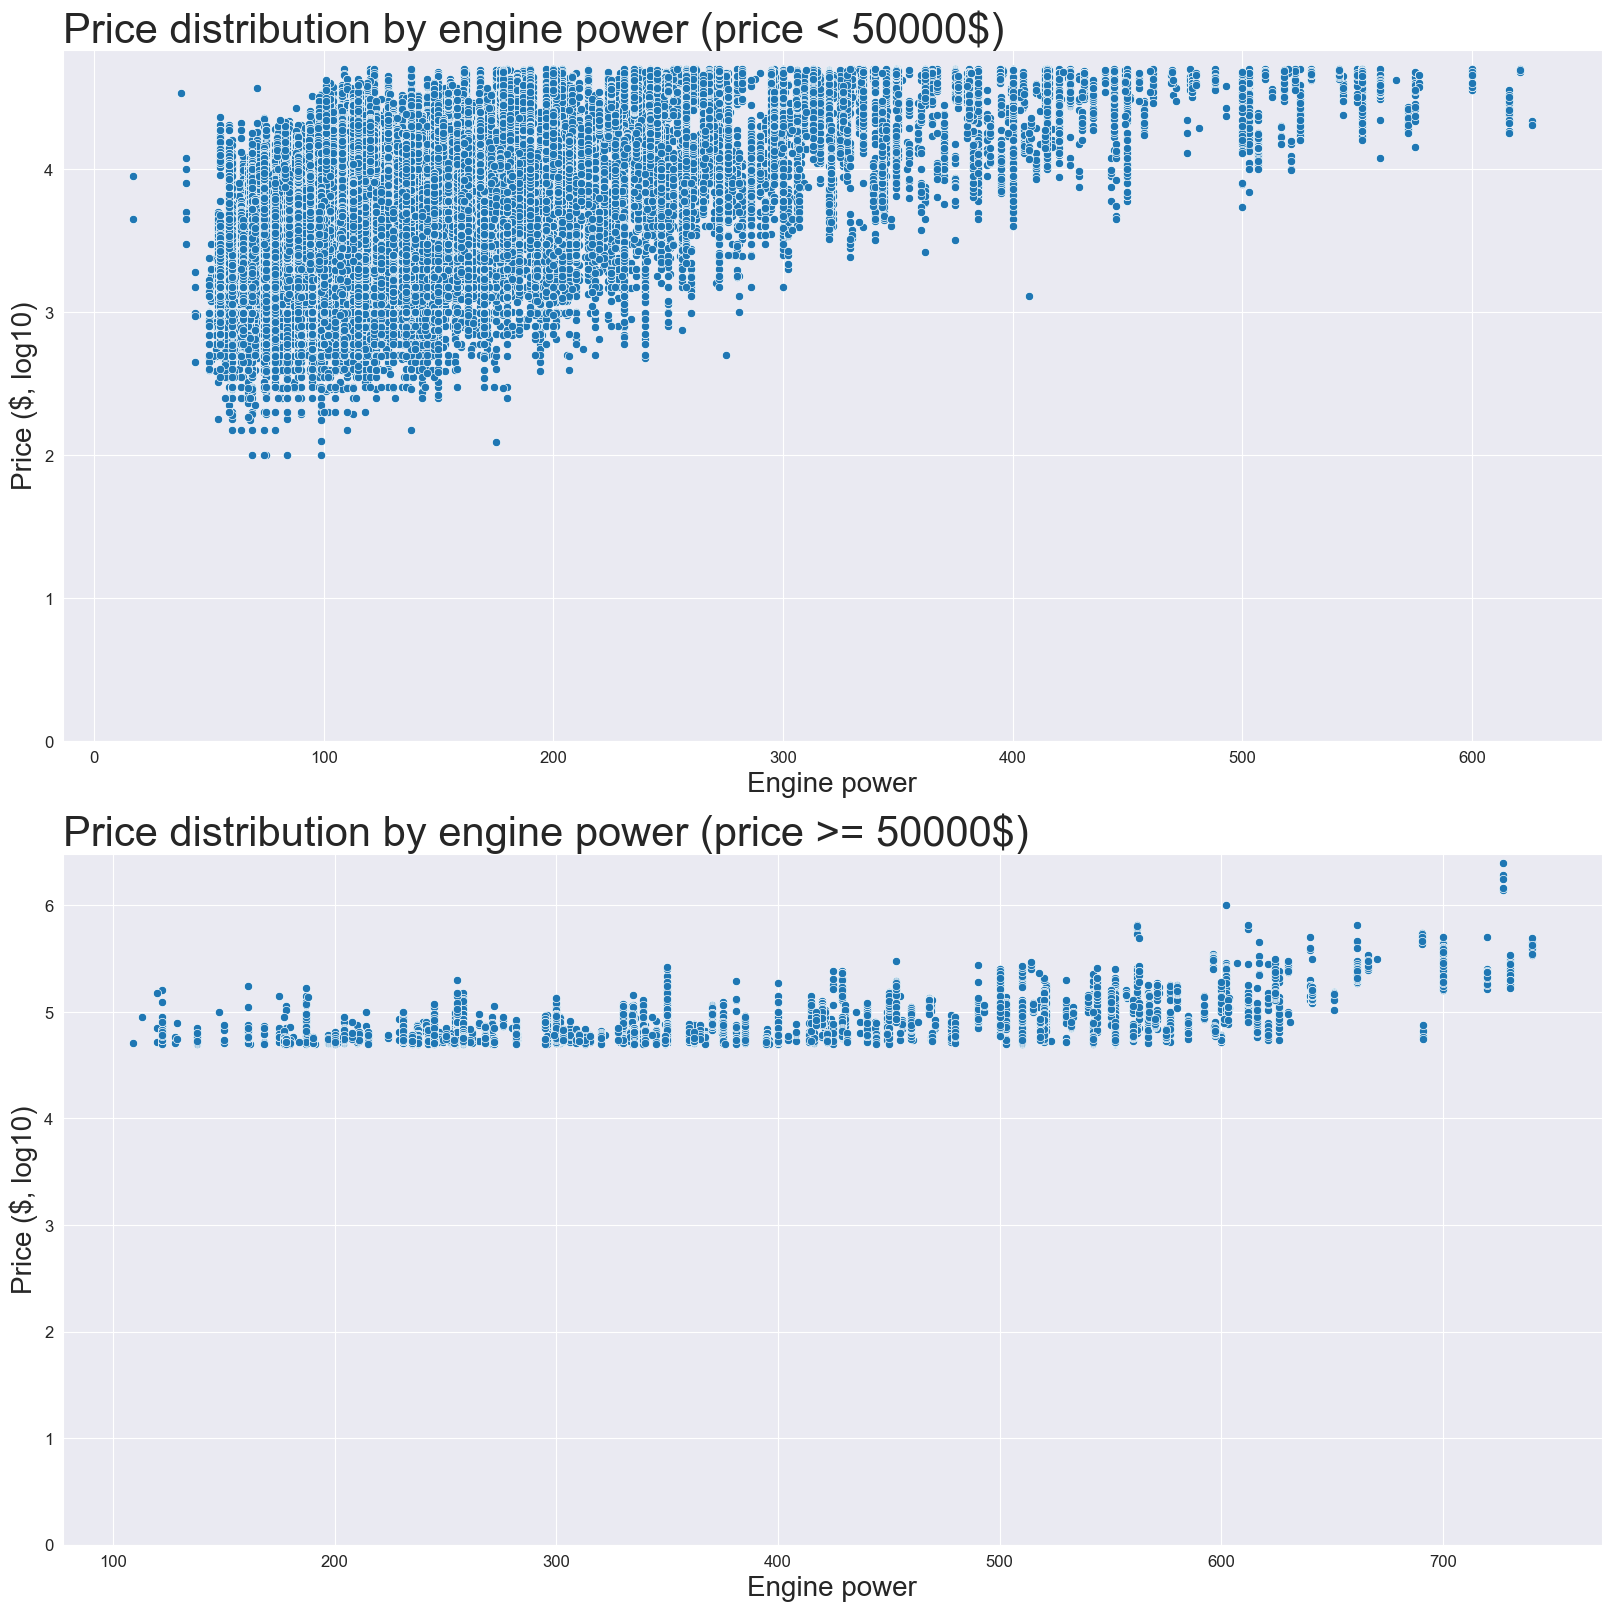

In [21]:
_, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(16, 16), layout='constrained')

sns.scatterplot(data=cheap_cars, x='engine_power', y='log_price', ax=ax0)
ax0.set_title('Price distribution by engine power (price < 50000$)', fontdict={'fontsize': 30}, loc='left')
ax0.set_xlabel('Engine power', fontdict={'fontsize': 20})
ax0.set_ylabel('Price ($, log10)', fontdict={'fontsize': 20})
ax0.tick_params(axis='both', which='major', labelsize=12)
ax0.set_ylim(ymin=0)

sns.scatterplot(data=expensive_cars, x='engine_power', y='log_price', ax=ax1)
ax1.set_title('Price distribution by engine power (price >= 50000$)', fontdict={'fontsize': 30}, loc='left')
ax1.set_xlabel('Engine power', fontdict={'fontsize': 20})
ax1.set_ylabel('Price ($, log10)', fontdict={'fontsize': 20})
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_ylim(ymin=0)

plt.show()

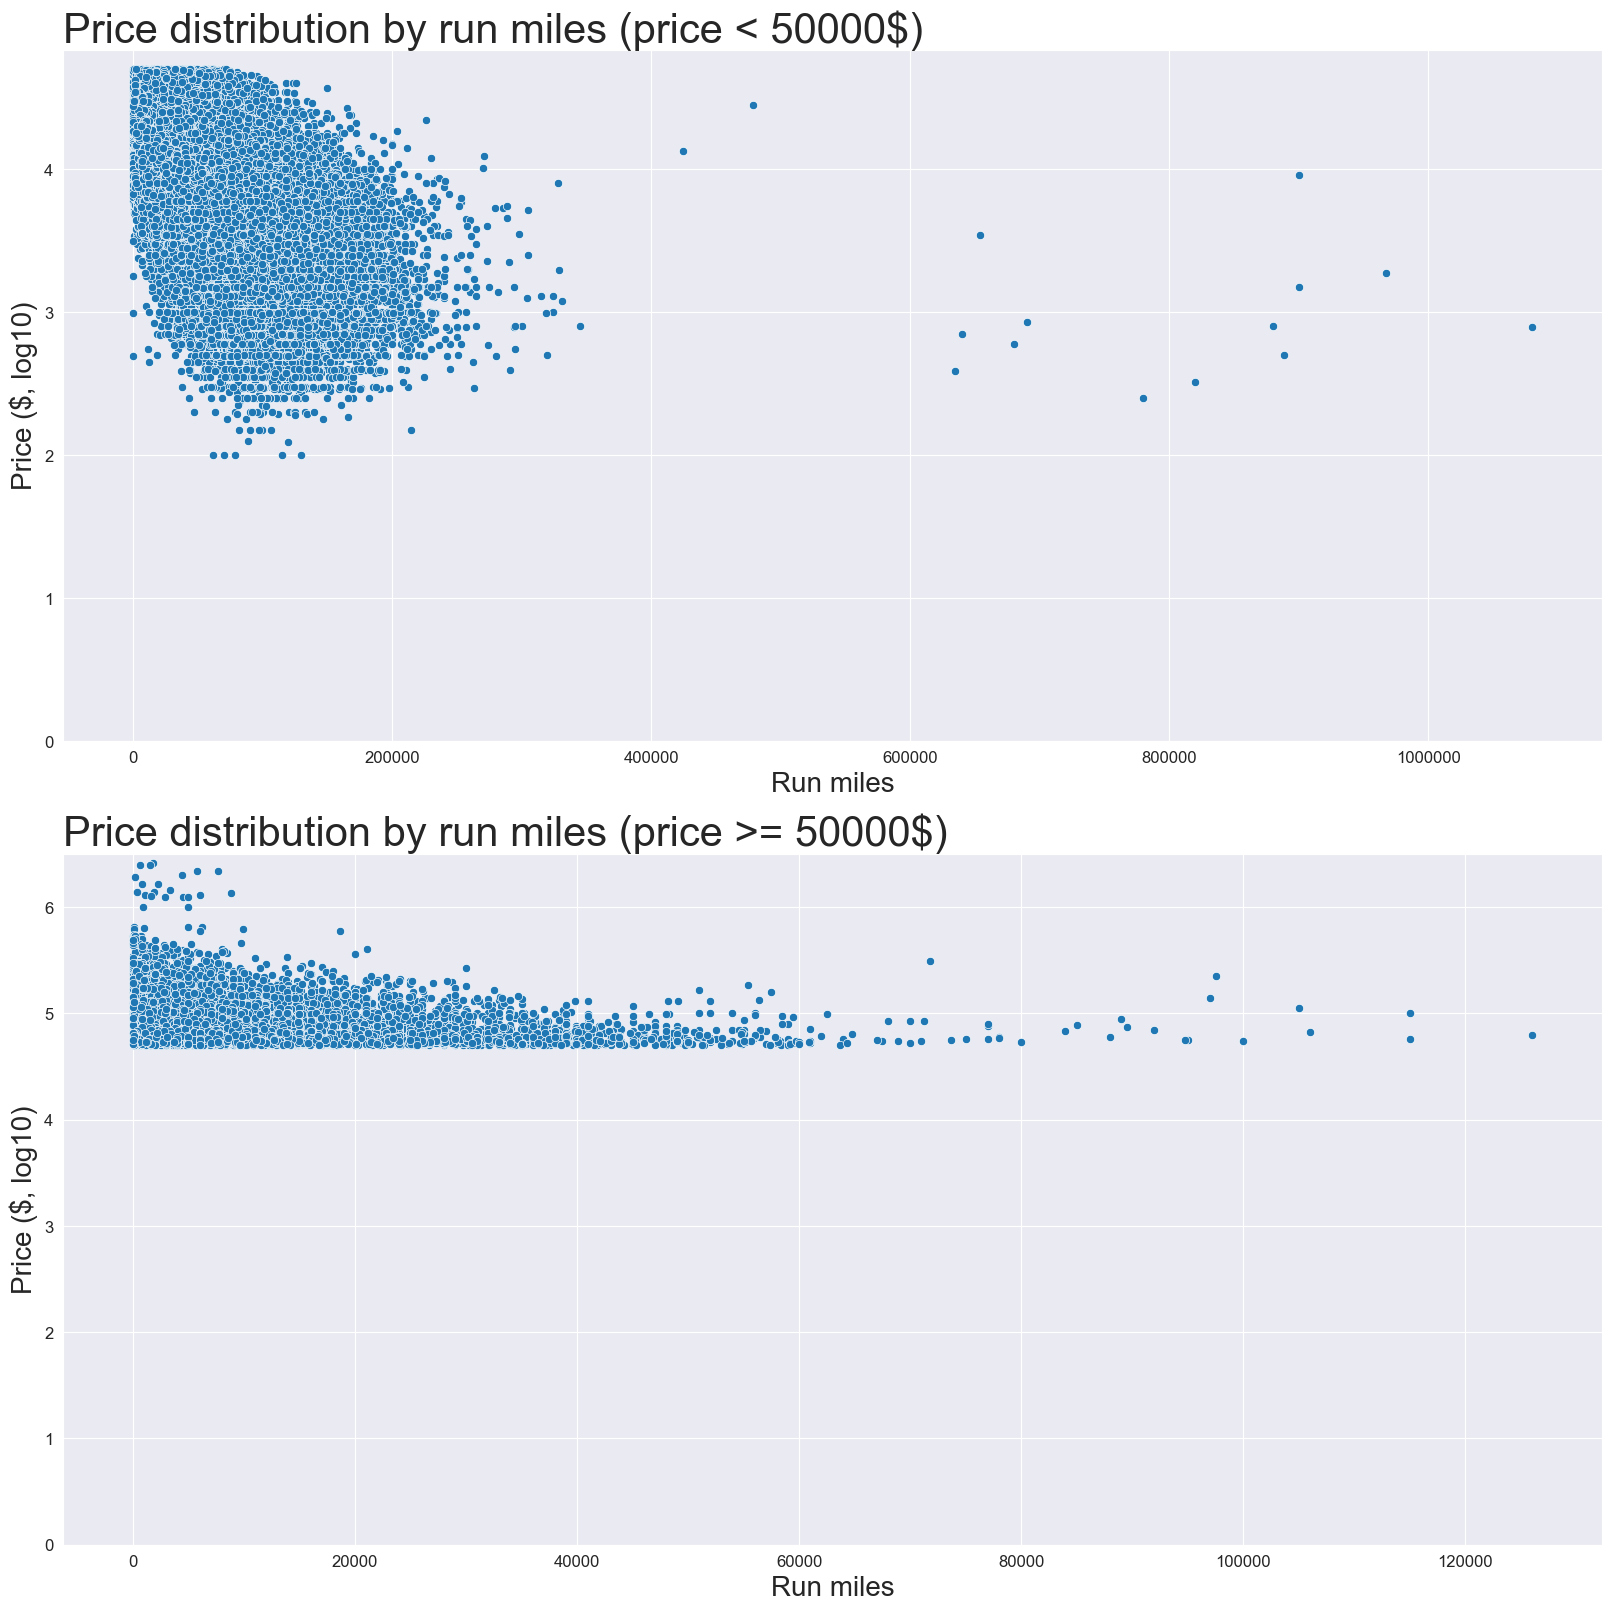

In [22]:
_, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(16, 16), layout='constrained')

sns.scatterplot(data=cheap_cars, x='run_miles', y='log_price', ax=ax0)
ax0.set_title('Price distribution by run miles (price < 50000$)', fontdict={'fontsize': 30}, loc='left')
ax0.set_xlabel('Run miles', fontdict={'fontsize': 20})
ax0.set_ylabel('Price ($, log10)', fontdict={'fontsize': 20})
ax0.tick_params(axis='both', which='major', labelsize=12)
ax0.set_ylim(ymin=0)
ax0.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

sns.scatterplot(data=expensive_cars, x='run_miles', y='log_price', ax=ax1)
ax1.set_title('Price distribution by run miles (price >= 50000$)', fontdict={'fontsize': 30}, loc='left')
ax1.set_xlabel('Run miles', fontdict={'fontsize': 20})
ax1.set_ylabel('Price ($, log10)', fontdict={'fontsize': 20})
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_ylim(ymin=0)
ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

plt.show()

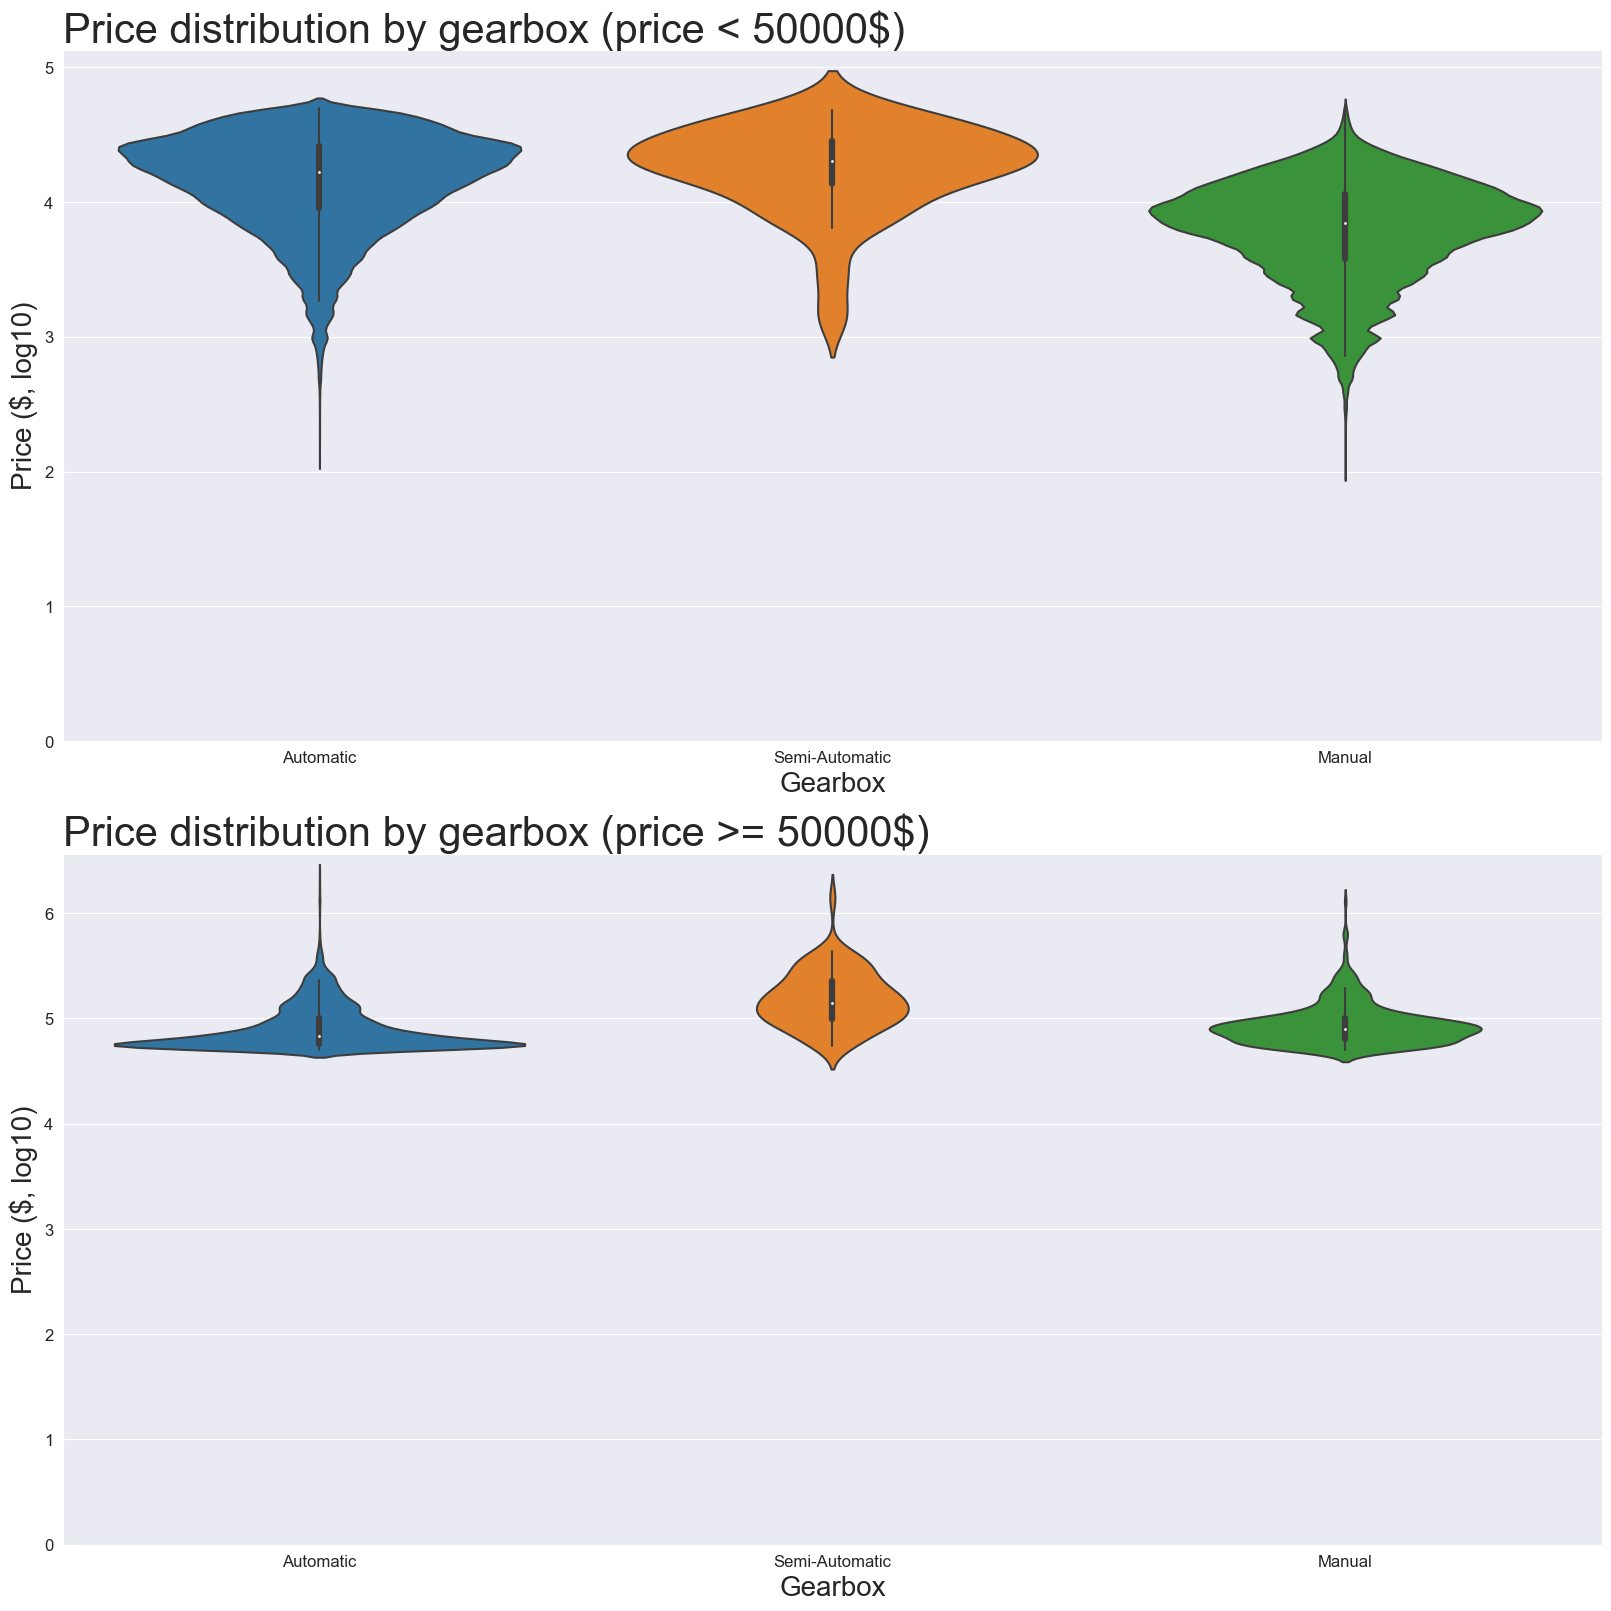

In [23]:
order = cars['gearbox'].dropna().unique().tolist()

_, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(16, 16), layout='constrained')

sns.violinplot(data=cheap_cars, x='gearbox', y='log_price', order=order, ax=ax0)
ax0.set_title('Price distribution by gearbox (price < 50000$)', fontdict={'fontsize': 30}, loc='left')
ax0.set_xlabel('Gearbox', fontdict={'fontsize': 20})
ax0.set_ylabel('Price ($, log10)', fontdict={'fontsize': 20})
ax0.tick_params(axis='both', which='major', labelsize=12)
ax0.set_ylim(ymin=0)

sns.violinplot(data=expensive_cars, x='gearbox', y='log_price', order=order, ax=ax1)
ax1.set_title('Price distribution by gearbox (price >= 50000$)', fontdict={'fontsize': 30}, loc='left')
ax1.set_xlabel('Gearbox', fontdict={'fontsize': 20})
ax1.set_ylabel('Price ($, log10)', fontdict={'fontsize': 20})
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_ylim(ymin=0)

plt.show()

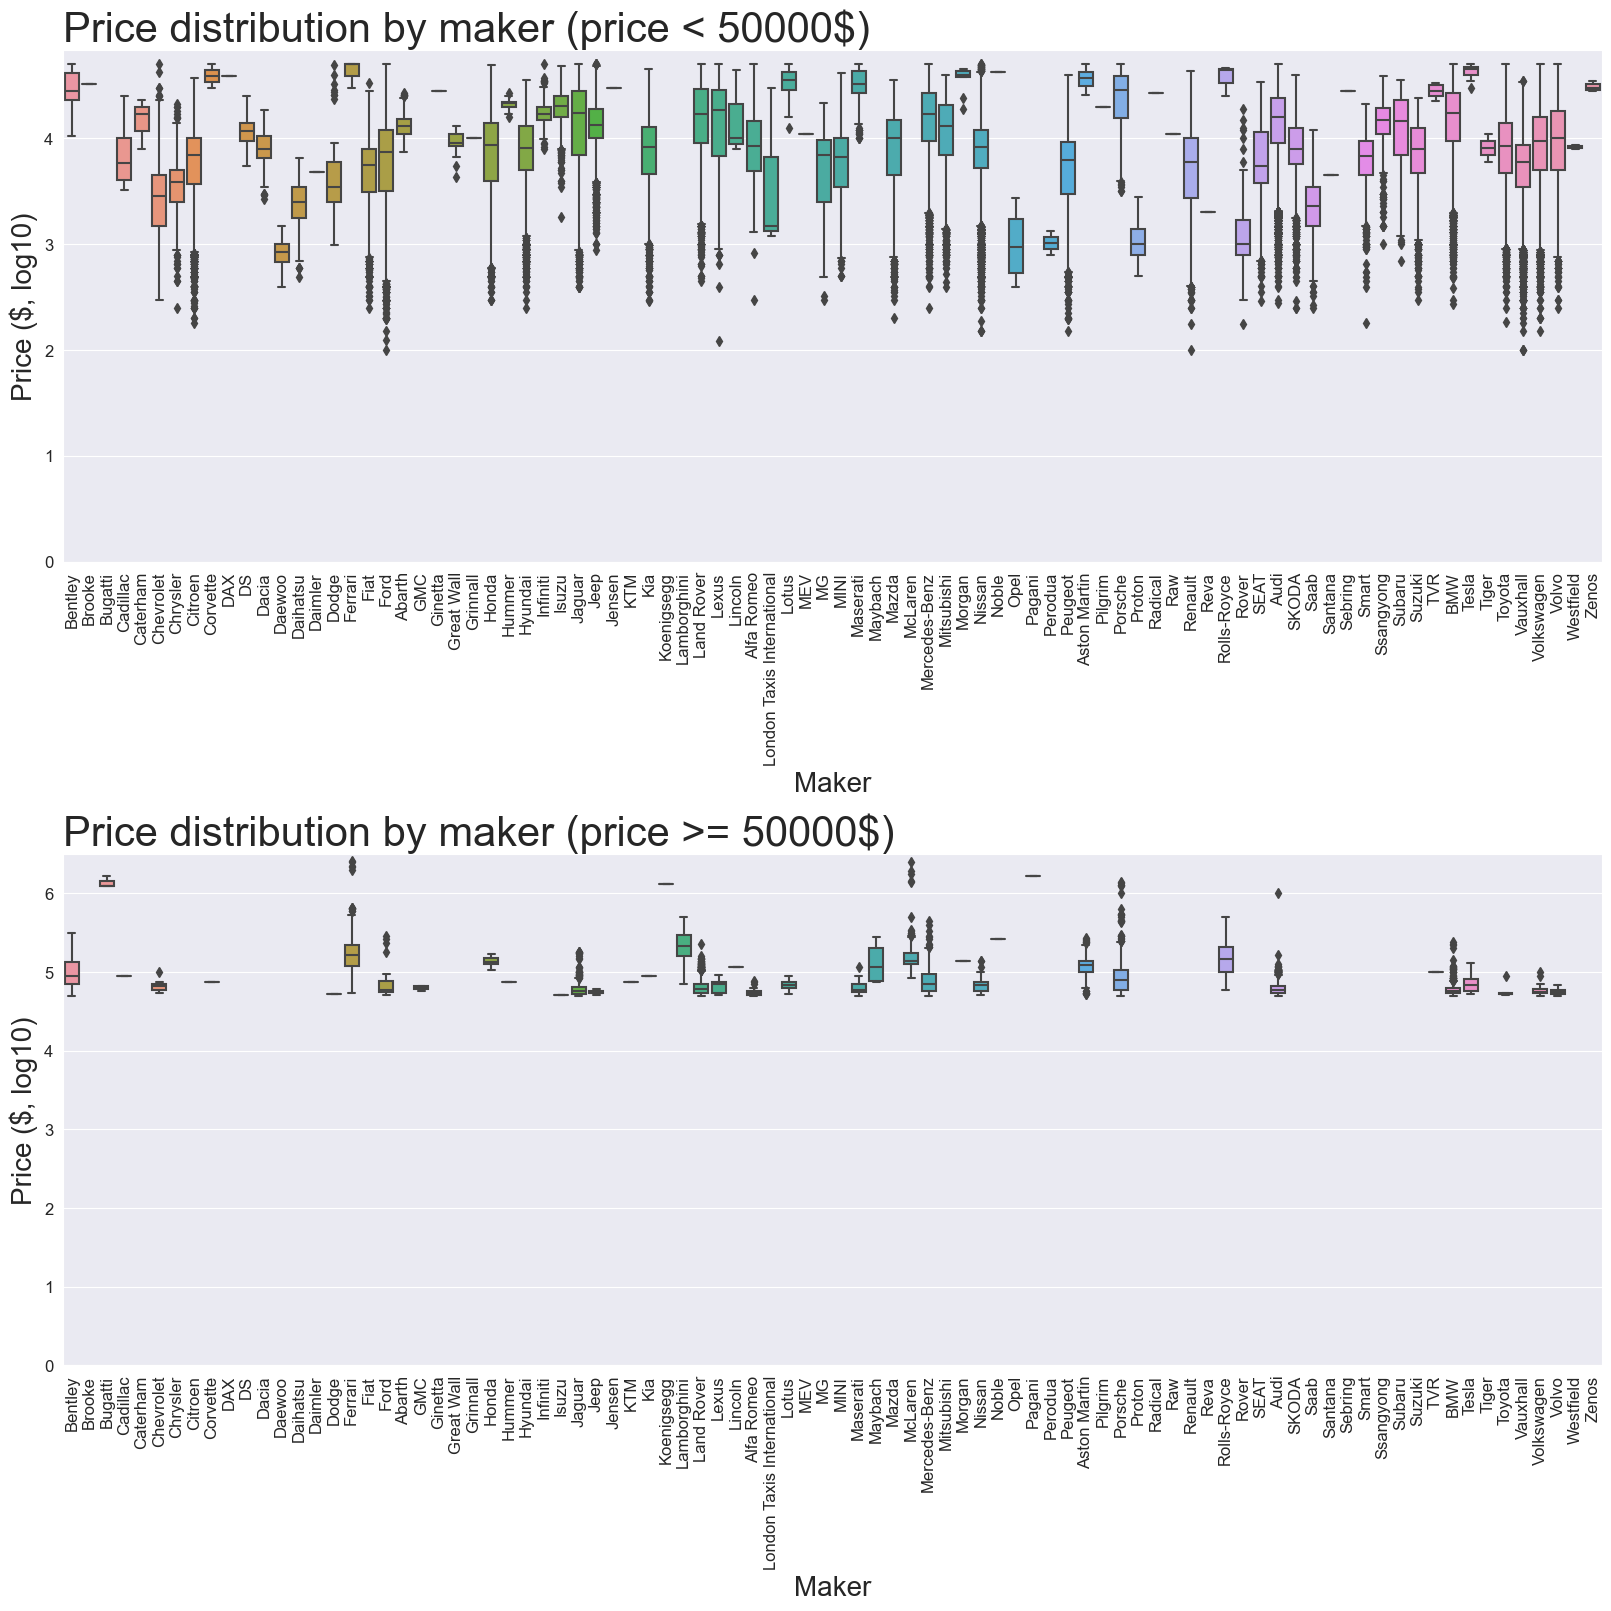

In [24]:
order = cars['maker'].dropna().unique().tolist()

_, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(16, 16), layout='constrained')

sns.boxplot(data=cheap_cars, x='maker', y='log_price', order=order, ax=ax0)
ax0.set_title('Price distribution by maker (price < 50000$)', fontdict={'fontsize': 30}, loc='left')
ax0.set_xlabel('Maker', fontdict={'fontsize': 20})
ax0.set_ylabel('Price ($, log10)', fontdict={'fontsize': 20})
ax0.tick_params(axis='both', which='major', labelsize=12)
ax0.set_ylim(ymin=0)
ax0.tick_params(axis='x', rotation=90)

sns.boxplot(data=expensive_cars, x='maker', y='log_price', order=order, ax=ax1)
ax1.set_title('Price distribution by maker (price >= 50000$)', fontdict={'fontsize': 30}, loc='left')
ax1.set_xlabel('Maker', fontdict={'fontsize': 20})
ax1.set_ylabel('Price ($, log10)', fontdict={'fontsize': 20})
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_ylim(ymin=0)
ax1.tick_params(axis='x', rotation=90)

plt.show()